<h1 style="text-align: center;">A Feature-Optimized Approach to Automatic Sleep Stage Classification: Combining Entropy Metrics with J-means Clustering</h1>


- Bouallou Youness (ENS Paris-Saclay)
- Mouna Naim (ENS Paris-Saclay)

In the following discussion, we will undertake a detailed and systematic analysis, carefully examining and critiquing each stage of the author's model implementation process step by step. Our focus will initially center on a single, illustrative case study—specifically, the example of `patient 18, night 2`—in order to provide a clear and thorough understanding of the model’s functionality in a real-world context. Following this focused examination, we will broaden our scope to evaluate the model’s average performance across a wider range of patients. By introducing subtle adjustments and exploring variations in different scenarios, we aim to gain deeper insights into the model’s behavior, robustness, and consistency when applied to diverse instances and conditions.

## 1. data explanation:

We start by importing the necessary libraries.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne # for .edf signal processing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from scipy.spatial.distance import cdist
import itertools
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import ConfusionMatrixDisplay
from collections import defaultdict
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# costum library/file
from utils import *  

We start by converting raw .edf data to .csv to see how it is structured.

In [2]:
# folder path of the data
path = "data"

# Convert .edf files specified to .csv format
PSG_to_csv(path) 
Hypnogram_to_csv(path)

# Paths to the converted CSV files
psg_csv_file = os.path.join(path, "SC4182E0-PSG.csv")
hyp_csv_file = os.path.join(path, "SC4182EC-Hypnogram.csv")

Extracting EDF parameters from D:\data projects & Tps\juputerr\MVA\data\SC4102E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


D:\data projects & Tps\juputerr\MVA\utilssss.py:24: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_psg = mne.io.read_raw_edf(psg_file, preload=True)
D:\data projects & Tps\juputerr\MVA\utilssss.py:24: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_psg = mne.io.read_raw_edf(psg_file, preload=True)
D:\data projects & Tps\juputerr\MVA\utilssss.py:24: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_psg = mne.io.read_raw_edf(psg_file, preload=True)


Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
EDF file has been converted and saved as: data\SC4102E0-PSG.csv
Annotations content:
<Annotations | 118 segments: Movement time (1), Sleep stage 1 (41), Sleep ...>
Hypnogram annotations have been converted and saved as: data\SC4102EC-Hypnogram.csv


In [3]:
psg_csv_file = os.path.join(path, "SC4182E0-PSG.csv")
print("PSG Data (First 5 rows):")
psg_df = pd.read_csv(psg_csv_file)
psg_df.head()

PSG Data (First 5 rows):


,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,Resp oro-nasal,EMG submental,Temp rectal,Event marker,Time (s)
0,0.000005,-9.637363e-06,-1.615922e-05,-313.000000,5.400000e-07,37.442206,624.000000,0.00
1,-0.000011,7.252747e-07,-6.145055e-06,-314.880339,5.475532e-07,37.444518,624.162503,0.01
2,-0.000009,-5.312088e-06,-2.116630e-05,-316.703712,5.550386e-07,37.446741,624.324819,0.02
3,-0.000008,4.690110e-06,-6.827839e-07,-318.469849,5.624522e-07,37.448874,624.486824,0.03
4,-0.000004,1.846154e-07,-1.433846e-05,-320.178524,5.697898e-07,37.450918,624.648394,0.04


In [4]:
psg_df.shape

(8526000, 8)

In [5]:
hyp_csv_file = os.path.join(path, "SC4182EC-Hypnogram.csv")
print("Hypnogram Data (First 5 rows):")
hyp_df = pd.read_csv(hyp_csv_file)
hyp_df.head()

Hypnogram Data (First 5 rows):


,Onset (s),Duration (s),Description
0,0.0,30390.0,Sleep stage W
1,30390.0,30.0,Sleep stage 1
2,30420.0,30.0,Sleep stage W
3,30450.0,60.0,Sleep stage 1
4,30510.0,30.0,Sleep stage W


In [6]:
hyp_df.shape

(108, 3)

We can see that the data contained in the `SC4182E0-PSG.csv` contains numerical informations about the evolution of events related to sleep physiology (e.g. EMG for muscle tone, ECG for heart rate..) with a corresponding time column to each event.

While the `SC4182EC-Hypnogram.edf` contains annotations specifically related to sleep staging, representing the structure of sleep throughout the recording.

The function defined in ```utilssss.py``` is used to read the raw PSG and Hypnogram annotations, extract relevant epochs of 30-second durations, Normalize the EEG signals across all epochs and channels for better consistency. This function returns a dictionary containg the following information: 

To classify and analyze sleep stages, we use the following mapping:

| **Sleep Stage** | **Label** |
|------------------|-----------|
| Wake (W)         | 1         |
| Light Sleep (N1) | 2         |
| Light Sleep (N2) | 3         |
| Deep Sleep (N3)  | 4         |
| REM Sleep (REM)  | 5         |

Going further we'll only be interested in the anlysis of `EEG Fpz-Cz` and `EEG Pz-Oz` columns as they correspond to signals collected from the difference in electrical potential between electrodes placed at Fpz (frontal pole) and Cz (central midline) then Pz (parietal midline) and Oz (occipital midline).

The following function `load_and_normalize_eeg_data` goes through all the pre-processing necessary steps, to hash the two channels into separate, labeled, epochs, then normalize it, and store various informations about it in the form of a dictionary. A brief check on the original functions is advised for a swift comprehension of the following steps.

In [7]:
# specify files path
psg_path = os.path.join(path, "SC4182E0-PSG.edf")
hyp_path = os.path.join(path,"SC4182EC-Hypnogram.edf")

# Dictionary of patient data
patient_data = load_and_normalize_eeg_data(psg_path, hyp_path)

Extracting EDF parameters from D:\data projects & Tps\juputerr\MVA\data\SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...


D:\data projects & Tps\juputerr\MVA\utilssss.py:113: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_file = mne.io.read_raw_edf(psg_file, preload=True)
D:\data projects & Tps\juputerr\MVA\utilssss.py:113: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_file = mne.io.read_raw_edf(psg_file, preload=True)
D:\data projects & Tps\juputerr\MVA\utilssss.py:113: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_file = mne.io.read_raw_edf(psg_file, preload=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
920 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 920 events and 3000 original time points ...
0 bad epochs dropped


In [8]:
print("PSG File:", patient_data['psg_name']) 
print("Hypnogram File:", patient_data['hypnogram_name'])
print("Subject ID:", patient_data['subject_id']) # Identifier for the patient
print("Night Number:", patient_data['night_number']) # Indicates the night of the recording
print("Annotation ID:", patient_data['annotation_id']) # Identifier for the annotation source
print("Shape of signal data:", patient_data['normalized_signal_data'].shape) # Normalized EEG data structured as (n_epochs, n_channels, n_time_steps)
print("Number of epochs:", len(patient_data['epoch_onset_times'])) # Array of onset times for each epoch.

PSG File: SC4182E0-PSG.edf
Hypnogram File: SC4182EC-Hypnogram.edf
Subject ID: 18
Night Number: 2
Annotation ID: 0
Shape of signal data: (920, 2, 3000)
Number of epochs: 920


In [9]:
## Load channels
eeg_fpz = patient_data['normalized_signal_data'][:, 0, :]  # Channel 1 (Fpz-Cz)
eeg_pz = patient_data['normalized_signal_data'][:, 1, :]  # Channel 2 (Pz-Oz)

# labels
labels = patient_data['labels']

# number of epochs
num_epochs = eeg_fpz.shape[0]
num_epochs

920

In [10]:
eeg_fpz.shape

(920, 3000)

Each epoch (30s) corresponds to a 3000 long time series.

# 2. Feature analysis

According to the article, the features are computed from the EEG signals. The features computed are: 
```
- FD features
- DFA features
- Shannon entropy features
- ApEn features
- SampEn features
- MSE features
```

In [11]:
# This function calculates the Fractal Dimension for each epoch
def FD(channel): # Normalized channels: eeg_fpz or eeg_pz
    rows, _ = channel.shape
    all_FD = []
    for i in range(rows):
        time_series = channel[i, :]
        fd_i = compute_fractal_dimension(time_series, 
                                        min_box_size=2, 
                                        max_box_size=200)  
        all_FD.append(fd_i)

    fd_moy = np.mean(all_FD)
    #print(f"Mean of FD : {fd_moy:.4f}")
    return all_FD

In [54]:
# for fpz channel
All_FD_fpz = FD(eeg_fpz)

In [55]:
# for pz channel
All_FD_pz = FD(eeg_pz)

-------------------------------------------------------------------

In [56]:
# This function calculates DFA for each epoch
def DFA(channel): # Normalized channels: eeg_fpz or eeg_pz
    rows, cols = channel.shape
    all_alpha = []
    all_a1 = []
    all_a2 = []
    for i in range(rows):
        time_series = channel[i, :]
        alpha, a1, a2 = compute_DFA(time_series)  
        all_alpha.append(alpha)
        all_a1.append(a1)
        all_a2.append(a2)

    #print(f"Mean of DFA-alpha for {channel}:", np.mean(all_alpha))
    #print(f"Mean of DFA-a1 for {channel}:", np.mean(all_a1))
    #print(f"Mean of DFA-a2 for {channel}:", np.mean(all_a2))
    return all_alpha, all_a1, all_a2

In [57]:
# for fpz channel
DFA_alpha_fpz, DFA_a1_fpz, DFA_a2_fpz = DFA(eeg_fpz)

In [58]:
# for pz channel
DFA_alpha_pz, DFA_a1_pz, DFA_a2_pz = DFA(eeg_pz)

-----------------

In [59]:
# This function calculates shanon entropy for each epoch
def shannon(channel):
    rows, cols = channel.shape
    all_shannon = []
    for i in range(rows):
        time_series = channel[i, :]
        fd_i = compute_shannon_entropy(time_series)  
        all_shannon.append(fd_i)

    #fd_moy = np.mean(all_shannon)
    #print(f"Mean of shannon entropy:", fd_moy)
    return all_shannon

In [60]:
# for fpz channel
H_Fpz_Cz = shannon(eeg_fpz)

In [61]:
# for pz channel
H_pz_Cz = shannon(eeg_pz)

------------------

In [62]:
# This function calculates App-en for each epoch
def approximate(channel): 
    rows, cols = channel.shape
    all_approximate = []
    for i in range(rows):
        time_series = channel[i, :]
        fd_i = compute_ApEn(time_series)  
        all_approximate.append(fd_i)

    #fd_moy = np.mean(all_approximate)
    #print(f"Mean of Approximate Entropy is:", fd_moy)
    return all_approximate

In [63]:
# for fpz channel
ApEn_Fpz = approximate(eeg_fpz)

Mean of Approximate Entropy is: 1.0868597094686945


In [64]:
# for pz channel
ApEn_pz = approximate(eeg_pz)

Mean of Approximate Entropy is: 1.0945685502193008


----------------------

In [65]:
# This function calculates Samp-en for each epoch
def sample(channel, m): 
    rows, cols = channel.shape
    all_sample = []
    for i in range(rows):
        time_series = channel[i, :]
        fd_i = compute_SampEn(time_series, m)  
        all_sample.append(fd_i)

    #fd_moy = np.mean(all_sample)
    #print(f"Moyenne est:", fd_moy)
    return all_sample

In [66]:
# for fpz channel
Samp_En_m0_Fpz = sample(eeg_fpz, 1)
Samp_En_m1_Fpz = sample(eeg_fpz, 2)

In [67]:
# for pz channel
Samp_En_m0_pz = sample(eeg_pz, 1)
Samp_En_m1_pz = sample(eeg_pz, 2)

-------------

In [ ]:
# This function calculates MSE for each epoch
def multiscale(channel, scale): 
    rows, cols = channel.shape
    all_multi = []
    for i in range(rows):
        time_series = channel[i, :]
        fd_i = compute_MSE(time_series, scale)  
        all_multi.append(fd_i)

    fd_moy = np.mean(all_multi)
    #print(f"Mean of MSE is:", fd_moy)

    return all_multi

MSE was computed for scales n = 1, 2, · · · , 9 for the two channels 

In [ ]:
scales = [i for i in range(1, 10)]  # Scales
channel1 = eeg_fpz  
channel2 = eeg_pz   

# Dictionaries to stock the results
results_channel1 = {}
results_channel2 = {}

# Loop on scales
for scale in scales:
    print(f"For {scale}")
    mse_channel1 = multiscale(channel1, scale)
    mse_channel2 = multiscale(channel2, scale)

    results_channel1[scale] = mse_channel1 #mse-fpz-{scale}
    results_channel2[scale] = mse_channel2 #mse-pz-{scale}

# 3. Feature analysis

After extracting features we get the following data set for our 920 epochs.

In [12]:
data = pd.read_csv("data\\features_updated2.csv")
data.head()

,time,All_FD_fpz,All_FD_pz,ApEn_Fpz,ApEn_pz,DFA_a1_fpz,DFA_a1_pz,DFA_a2_fpz,DFA_a2_pz,DFA_alpha_fpz,...,mse-pz-5,mse-pz-6,mse-pz-7,mse-pz-8,mse-pz-9,Samp_En_m0_Fpz,Samp_En_m0_pz,Samp_En_m1_Fpz,Samp_En_m1_pz,labels
0,2859000,1.502678,1.640479,1.388133,1.848967,1.255167,0.766789,0.583470,0.716490,0.992283,...,2.060532,2.021532,2.043913,1.926283,1.975604,1.409055,2.000796,1.293187,1.946762,1
1,2862000,1.487424,1.611964,1.397980,1.828502,1.296872,0.797256,0.548436,0.704583,0.966688,...,1.822233,1.879610,1.969146,1.882559,1.901369,1.393069,1.971841,1.268138,1.917598,1
2,2865000,1.496229,1.658674,1.414244,1.920771,1.300667,0.827700,0.482563,0.703694,0.956314,...,1.976619,1.865024,2.007833,2.025844,1.868786,1.397984,2.095451,1.307281,2.054336,1
3,2868000,1.500582,1.624547,1.455110,1.860073,1.172220,0.793683,0.521576,0.732292,0.880724,...,1.992561,1.963435,1.895736,1.849119,1.999420,1.446867,2.012025,1.309624,1.963986,1
4,2871000,1.490547,1.659485,1.344430,1.910005,1.282460,0.788342,0.591922,0.615493,0.987118,...,2.126806,2.056674,1.938819,1.971207,1.884786,1.337843,2.089282,1.234526,2.037655,1


In [13]:
data.columns

Index(['time', 'All_FD_fpz', 'All_FD_pz', 'ApEn_Fpz', 'ApEn_pz', 'DFA_a1_fpz',
       'DFA_a1_pz', 'DFA_a2_fpz', 'DFA_a2_pz', 'DFA_alpha_fpz', 'DFA_alpha_pz',
       'H_Fpz_Cz', 'H_pz_Cz', 'mse-fpz-1', 'mse-fpz-2', 'mse-fpz-3',
       'mse-fpz-4', 'mse-fpz-5', 'mse-fpz-6', 'mse-fpz-7', 'mse-fpz-8',
       'mse-fpz-9', 'mse-pz-1', 'mse-pz-2', 'mse-pz-3', 'mse-pz-4', 'mse-pz-5',
       'mse-pz-6', 'mse-pz-7', 'mse-pz-8', 'mse-pz-9', 'Samp_En_m0_Fpz',
       'Samp_En_m0_pz', 'Samp_En_m1_Fpz', 'Samp_En_m1_pz', 'labels'],
      dtype='object')

In [14]:
data.shape

(920, 36)

We extract the feature columns, then try to normalize them, and then explore each one of them.

In [15]:
# only leave features
scaler = StandardScaler()
X = data.drop(columns=['time', 'labels']).values
X_normalized = scaler.fit_transform(X)
X_normalized.shape

(920, 34)

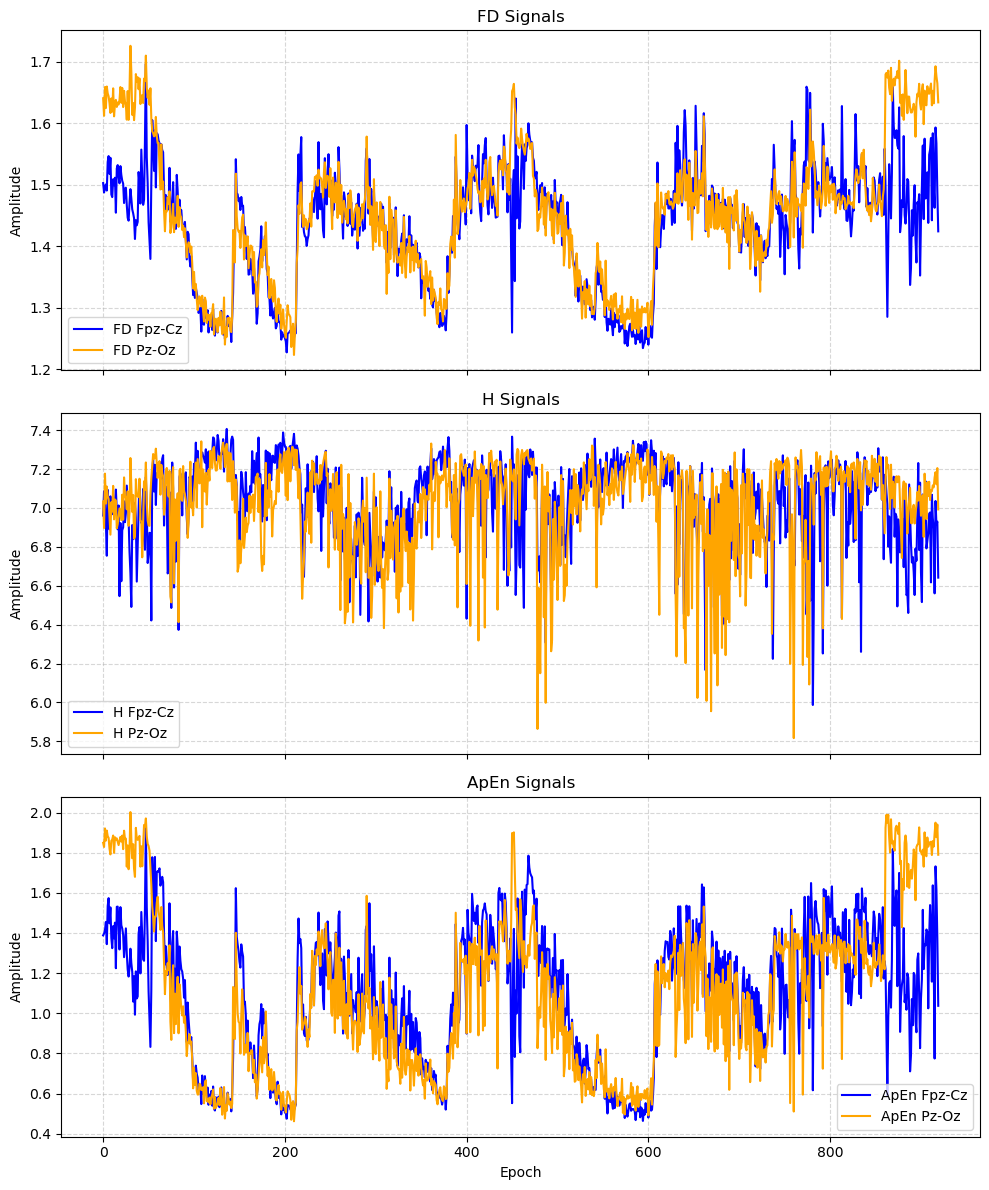

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# First plot: FD Fpz-Cz and FD Pz-Oz
axs[0].plot(data['All_FD_fpz'], label='FD Fpz-Cz', color='blue')
axs[0].plot(data['All_FD_pz'], label='FD Pz-Oz', color='orange')
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].set_title('FD Signals', fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Second plot: H Fpz-Cz and H Pz-Oz
axs[1].plot(data['H_Fpz_Cz'], label='H Fpz-Cz', color='blue')
axs[1].plot(data['H_pz_Cz'], label='H Pz-Oz', color='orange')
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].set_title('H Signals', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.5)

# Third plot: ApEn Fpz-Cz and ApEn Pz-Oz
axs[2].plot(data['ApEn_Fpz'], label='ApEn Fpz-Cz', color='blue')
axs[2].plot(data['ApEn_pz'], label='ApEn Pz-Oz', color='orange')
axs[2].set_xlabel('Epoch', fontsize=10)
axs[2].set_ylabel('Amplitude', fontsize=10)
axs[2].set_title('ApEn Signals', fontsize=12)
axs[2].legend(fontsize=10)
axs[2].grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

We can see above that FD, H, and ApEN have the same scale and variation with regard to each channel (Fpz or pz), through the epochs.

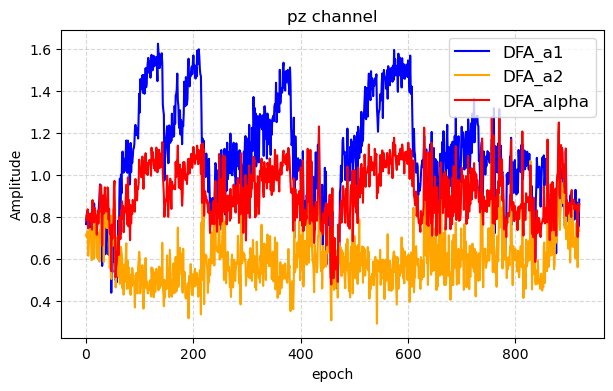

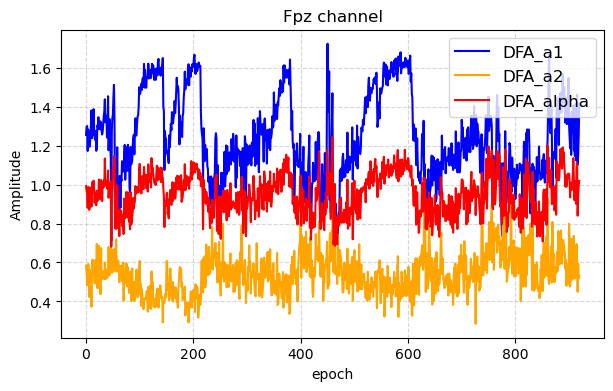

In [17]:
# only for pz channel
plt.figure(figsize=(7, 4))
plt.plot(data['DFA_a1_pz'], label='DFA_a1', color='blue')
plt.plot(data['DFA_a2_pz'], label='DFA_a2', color='orange')
plt.plot(data['DFA_alpha_pz'], label='DFA_alpha', color='red')
plt.title("pz channel")
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)


# Fpz channel
plt.figure(figsize=(7, 4))
plt.plot(data['DFA_a1_fpz'], label='DFA_a1', color='blue')
plt.plot(data['DFA_a2_fpz'], label='DFA_a2', color='orange')
plt.plot(data['DFA_alpha_fpz'], label='DFA_alpha', color='red')
plt.title("Fpz channel")
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Show the plots
plt.show()

For both the Fpz and pz channels, we can see that generally, the epochs indicate smoother and more correlated behavior at short time scales from the high $\alpha_1$ values, while the low values of $\alpha_2$ indicate weaker long-range dependencies.

There is a correlation between the values of $\alpha$ and $\alpha_1$, which would theoritically pose a potential threat of redunduncy of a feature column in the future.

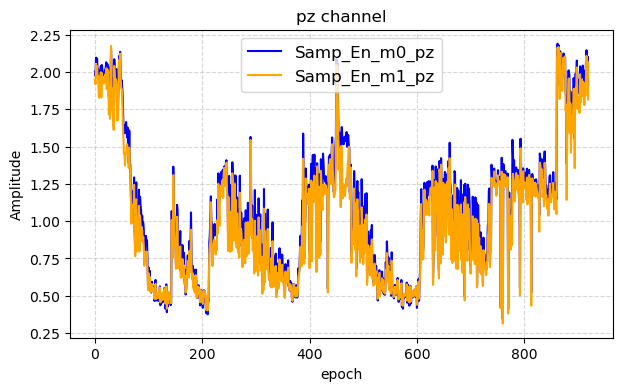

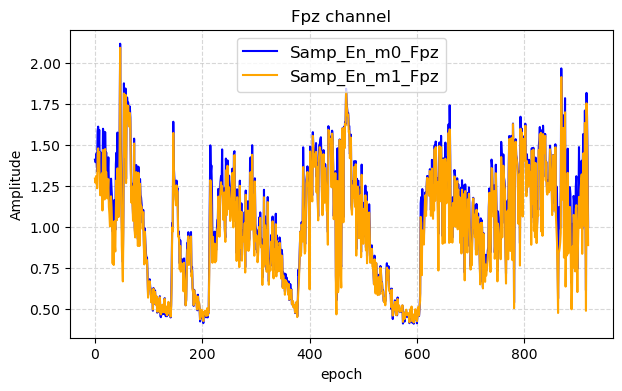

In [18]:
# pz channel
plt.figure(figsize=(7, 4))
plt.plot(data['Samp_En_m0_pz'], label='Samp_En_m0_pz', color='blue')
plt.plot(data['Samp_En_m1_pz'], label='Samp_En_m1_pz', color='orange')
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.title("pz channel")

# Fpz channel
plt.figure(figsize=(7, 4))
plt.plot(data['Samp_En_m0_Fpz'], label='Samp_En_m0_Fpz', color='blue')
plt.plot(data['Samp_En_m1_Fpz'], label='Samp_En_m1_Fpz', color='orange')
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.title("Fpz channel")

# Show the plot
plt.show()

There is a strikingly high correlation between the sample entropy values calculated for the epochs when comparing m=1 and m=2. A similar pattern was observed in the Fpz channel, raising concerns about potential feature redundancy.

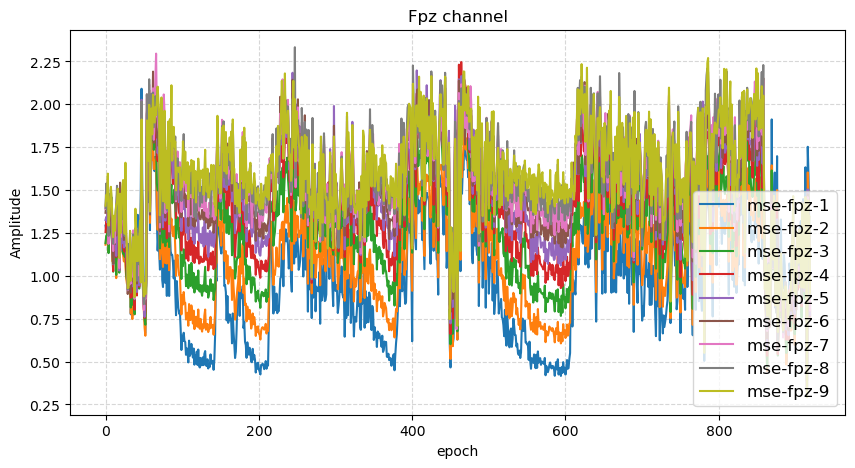

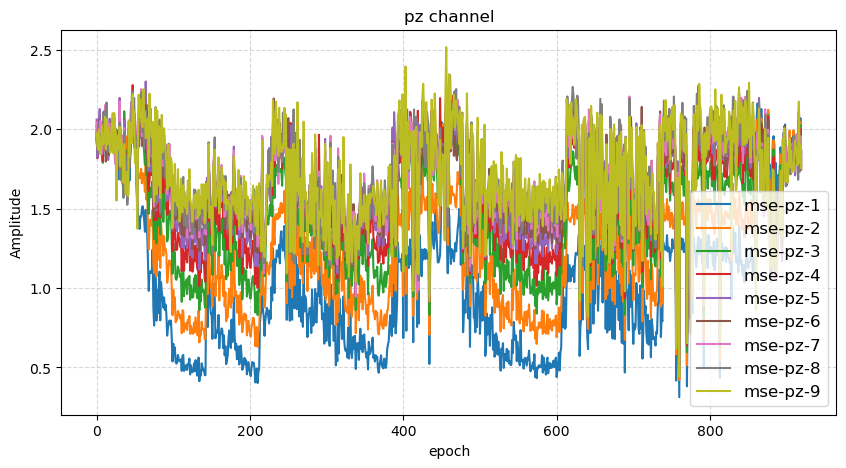

In [19]:
# fpz channel
plt.figure(figsize=(10, 5))
for i in range(1,10):
    plt.plot(data['mse-fpz-'+str(i)], label='mse-fpz-'+str(i))
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.title("Fpz channel")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# pz channel
plt.figure(figsize=(10, 5))
for i in range(1,10):
    plt.plot(data['mse-pz-'+str(i)], label='mse-pz-'+str(i))
plt.xlabel('epoch', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.title("pz channel")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Show the plot
plt.show()

For MSE, the values obtained for epochs are decently correlated. As $\tau$ increases, the coarse-graining process averages $\tau$ adjacent points, effectively acting as a low-pass filter. The high value of MSE values obtained for greater $\tau$s suggest that the low frequency components are more complex, either for the Fpz or the pz channel.

--------------

### Q-$\alpha$ for feature selection

After the feature extraction phase and normalization of the data, we get a total of 34 features per each epoch. We apply Q-alpha algorithm to get only the relevant features with regard to a certain threshold.

In [20]:
def q_alpha(W, variance_criterion=0.98):
    """
    Q-alpha algorithm for feature relevance analysis.
    
    Parameters:
    -----------
    W : array-like of shape (n_samples, n_features)
        Input matrix containing feature vectors
    variance_criterion : float, default=0.98
        Accumulated variance criterion threshold
        
    Returns:
    --------
    selected_features : array
        Indices of selected relevant features
    feature_weights : array
        Importance weights for all features
    """
    # Ensure input is a numpy array
    W = np.array(W, dtype=np.float64)
    p, q = W.shape  # p samples, q features
    
    # Initialize alpha vector
    alpha = np.ones(q) / q
    
    # Calculate eigenvectors and eigenvalues of W^T W
    eigenvals, eigenvecs = np.linalg.eigh(W.T @ W)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    # Calculate cumulative explained variance ratio
    explained_variance_ratio = eigenvals / eigenvals.sum()
    cumsum_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components needed to reach variance criterion
    n_components = np.sum(cumsum_variance < variance_criterion) + 1
    
    # Calculate Q matrix (first n_components eigenvectors)
    Q = eigenvecs[:, :n_components]  # Shape: (q, n_components)
    
    # Update alpha vector using the Q matrix
    alpha_new = np.zeros_like(alpha)
    for j in range(q):
        # Compute the sum of squared loadings for feature j across selected components
        alpha_new[j] = np.sum(Q[j, :] ** 2)
    
    # Normalize alpha to get feature weights
    feature_weights = normalize(alpha_new.reshape(1, -1), norm='l1')[0]
    
    # Select features based on importance
    selected_features = np.argsort(-feature_weights)[:n_components]
    
    return selected_features, feature_weights

In [21]:
# Apply Q-alpha algorithm
selected_features, feature_weights = q_alpha(X_normalized) # with 0.98 threshold used

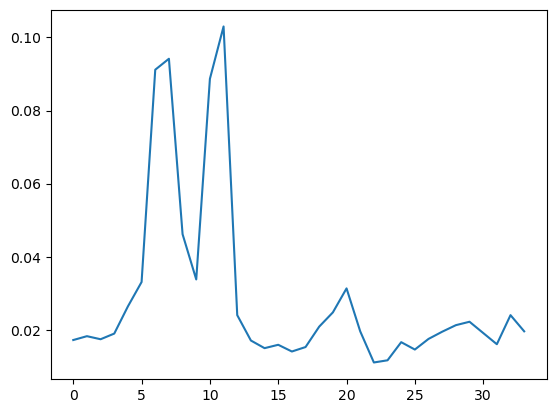

In [22]:
plt.plot(feature_weights)

`X_reduced` has only the desired features from `X_normalized`.

In [23]:
X_reduced = X[:, selected_features]
print("number of features before reduction: ",X_normalized.shape[1])
print("number of features after reduction: ",X_reduced.shape[1])
feature_names = data.columns.tolist()

number of features before reduction:  34
number of features after reduction:  9


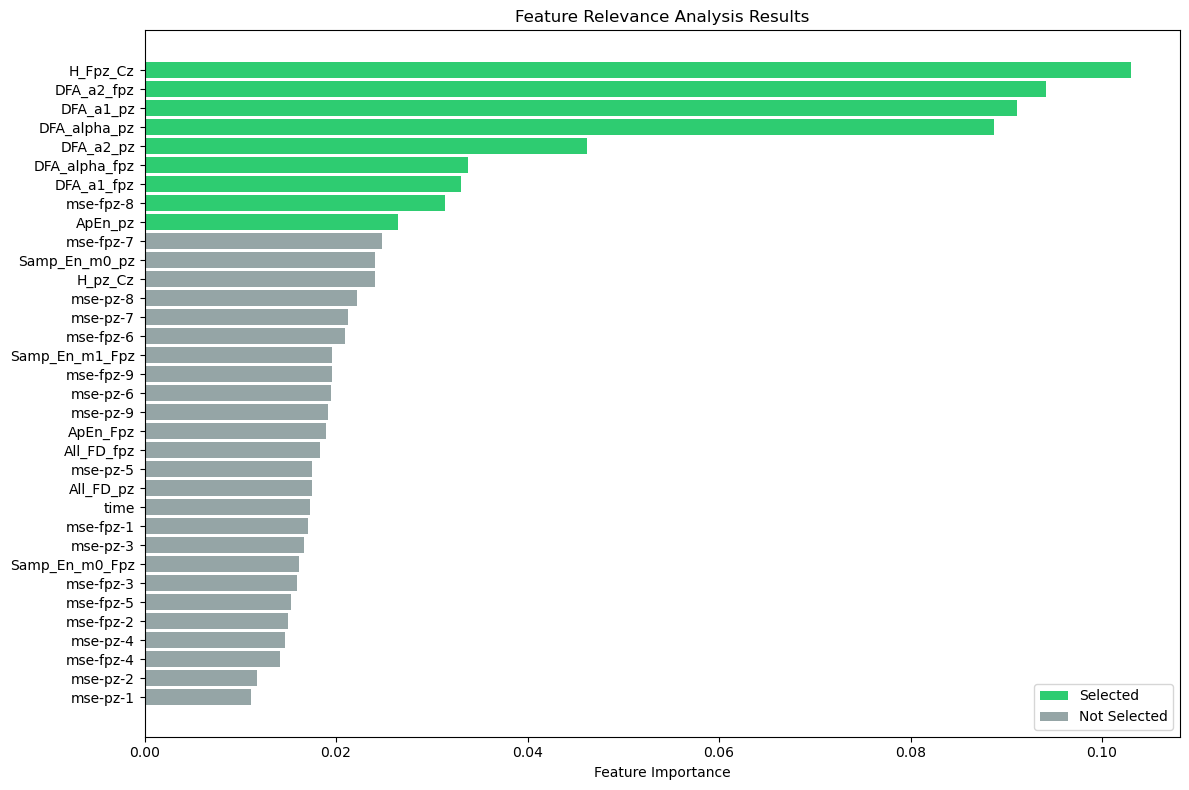


Selected Features:
-----------------
H_Fpz_Cz: 0.1030
DFA_a2_fpz: 0.0942
DFA_a1_pz: 0.0912
DFA_alpha_pz: 0.0887
DFA_a2_pz: 0.0462
DFA_alpha_fpz: 0.0338
DFA_a1_fpz: 0.0331
mse-fpz-8: 0.0314
ApEn_pz: 0.0264


In [24]:
plt.figure(figsize=(12, 8))

# Create color array (blue for selected, gray for non-selected)
colors = ['#2ecc71' if i in selected_features else '#95a5a6' 
          for i in range(len(feature_weights))]

# Sort features by importance
sorted_idx = np.argsort(feature_weights)
pos = np.arange(len(feature_weights)) + .5

# Create horizontal bar plot
plt.barh(pos, feature_weights[sorted_idx], align='center', color=[colors[i] for i in sorted_idx])

# Customize the plot
plt.yticks(pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Relevance Analysis Results')

# Add a legend
legend_elements = [Patch(facecolor='#2ecc71', label='Selected'),
                  Patch(facecolor='#95a5a6', label='Not Selected')]
plt.legend(handles=legend_elements, loc='lower right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print selected features and their importance scores
print("\nSelected Features:")
print("-----------------")
for idx in selected_features:
    print(f"{feature_names[idx]}: {feature_weights[idx]:.4f}")

---------

### J-means for clustering

Additionally, the clustering is applied to three different sets of features:
1. All features  
2. Top relevant features according to $Q-\alpha$  

In [25]:
event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        #'Sleep_stage 4': 3,
        'Sleep stage R': 5
    }

In [26]:
# the following implementation is exactly done as the paper proposes

def j_means_clustering(features, n_clusters=5, tolerance_factor=4):
    """
    J-means clustering
    """
    # Initialize with random centroids
    n_samples = features.shape[0]
    centroids = features[np.random.choice(n_samples, n_clusters, replace=False)]
    labels = np.zeros(n_samples, dtype=int)
    
    while True:
        old_labels = labels.copy()
        
        # Assign points to nearest centroid
        distances = np.array([np.linalg.norm(features - c, axis=1) for c in centroids])
        labels = np.argmin(distances, axis=0)
        
        # Find unoccupied points
        intra_distances = []
        for i in range(n_clusters):
            mask = labels == i
            if np.any(mask):
                intra_distances.extend(distances[i, mask])
        
        threshold = tolerance_factor * np.std(intra_distances)
        min_distances = np.min(distances, axis=0)
        unoccupied = np.where(min_distances > threshold)[0]
        
        if len(unoccupied) == 0 or np.all(labels == old_labels):
            break
            
        # Update centroids
        for i in range(n_clusters):
            mask = labels == i
            if np.any(mask):
                centroids[i] = np.mean(features[mask], axis=0)
    
    return labels

Now we're going to look for the optimal label assignement, we define it as the one that reaches the highest accuracy score after shuffling the numbers between each other.

In [27]:
def best_cluster_assignment(y, pred):
    """
    :param y: true labels
    :param pred: cluster assignment

    :return dict that maps clusters to a label
    """
    all_perm = list(itertools.permutations([1,2,3,4,5]))
    best_acc  = 0
    for perm in all_perm:
        cluster_to_label = {}
        for i in range(len(perm)):
            cluster_to_label[i] = perm[i]
        pred_label = [cluster_to_label[cluster] for cluster in pred]
        acc = accuracy_score(y, pred_label)
        if acc > best_acc:
            best_acc = acc
            best_pred = pred_label
    return np.array(best_pred)

In [28]:
y = np.array(data["labels"].astype(int))
#np.unique(y)

# prediction by jmeans
pred = j_means_clustering(X_normalized)
predd = best_cluster_assignment(y, pred) # optimal cluster assignement

Now we see the overall performance of the clustering operation, we'll try to show the results of the labels obtained using the data with full features.

In [29]:
def evaluate_mapping(true_labels, mapped_labels):
    """
    Calculate performance metrics after mapping
    """
    
    
    accuracy = accuracy_score(true_labels, mapped_labels)
    kappa = cohen_kappa_score(true_labels, mapped_labels)
    conf_mat = confusion_matrix(true_labels, mapped_labels)
    
    # Calculate per-stage metrics
    stages = np.unique(true_labels)
    per_stage_metrics = {}
    for stage in stages:
        true_pos = np.sum((true_labels == stage) & (mapped_labels == stage))
        false_pos = np.sum((true_labels != stage) & (mapped_labels == stage))
        false_neg = np.sum((true_labels == stage) & (mapped_labels != stage))
        
        recall = true_pos / (true_pos + false_neg)
        precision = true_pos / (true_pos + false_pos)
        
        per_stage_metrics[stage] = {
            'recall': recall,
            'precision': precision
        }
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'confusion_matrix': conf_mat,
        'per_stage_metrics': per_stage_metrics
    }

In [30]:
met = evaluate_mapping(y, predd)

Let's try to refine the visualization.

In [31]:
def visualize_results(metrics, stage_names=None):
    """
    Visualize classification results with multiple plots
    
    Args:
    metrics: Output dictionary from evaluate_mapping
    stage_names: Optional dictionary mapping stage numbers to names
                e.g., {1: 'W', 2: 'N1', 3: 'N2', 4: 'N3', 5: 'REM'}
    """
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = metrics['confusion_matrix']
    if stage_names:
        labels = [stage_names[i] for i in sorted(stage_names.keys())]
    else:
        labels = sorted(list(set([i for i in range(len(cm))])))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # 2. Per-stage Recall and Precision
    ax2 = fig.add_subplot(gs[0, 1])
    stages = list(metrics['per_stage_metrics'].keys())
    recalls = [metrics['per_stage_metrics'][s]['recall'] for s in stages]
    precisions = [metrics['per_stage_metrics'][s]['precision'] for s in stages]
    
    x = np.arange(len(stages))
    width = 0.35
    
    ax2.bar(x - width/2, recalls, width, label='Recall')
    ax2.bar(x + width/2, precisions, width, label='Precision')
    
    if stage_names:
        ax2.set_xticks(x)
        ax2.set_xticklabels([stage_names[s] for s in stages])
    else:
        ax2.set_xticks(x)
        ax2.set_xticklabels(stages)
        
    ax2.set_ylabel('Score')
    ax2.set_title('Per-stage Performance')
    ax2.legend()
    
    # 3. Overall Metrics
    ax3 = fig.add_subplot(gs[0, 2])
    overall_metrics = [metrics['accuracy'], metrics['kappa']]
    ax3.bar(['Accuracy', 'Kappa'], overall_metrics)
    ax3.set_ylim([0, 1])
    ax3.set_title('Overall Performance')
    
    # 4. F1 Scores
    ax4 = fig.add_subplot(gs[1, 0])
    f1_scores = []
    for stage in stages:
        recall = metrics['per_stage_metrics'][stage]['recall']
        precision = metrics['per_stage_metrics'][stage]['precision']
        if recall + precision > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)
    
    ax4.bar(stages, f1_scores)
    if stage_names:
        ax4.set_xticks(range(len(stages)))
        ax4.set_xticklabels([stage_names[s] for s in stages])
    ax4.set_title('F1 Scores by Stage')
    ax4.set_ylim([0, 1])
    
    # 5. Normalized Confusion Matrix
    ax5 = fig.add_subplot(gs[1, 1])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax5)
    ax5.set_title('Normalized Confusion Matrix')
    ax5.set_xlabel('Predicted')
    ax5.set_ylabel('True')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\nNumerical Results:")
    print(f"Overall Accuracy: {metrics['accuracy']:.3f}")
    print(f"Kappa Score: {metrics['kappa']:.3f}")
    print("\nPer-stage Results:")
    for stage in stages:
        stage_name = stage_names[stage] if stage_names else stage
        recall = metrics['per_stage_metrics'][stage]['recall']
        precision = metrics['per_stage_metrics'][stage]['precision']
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        print(f"\nStage {stage_name}:")
        print(f"  Recall: {recall:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  F1-Score: {f1:.3f}")

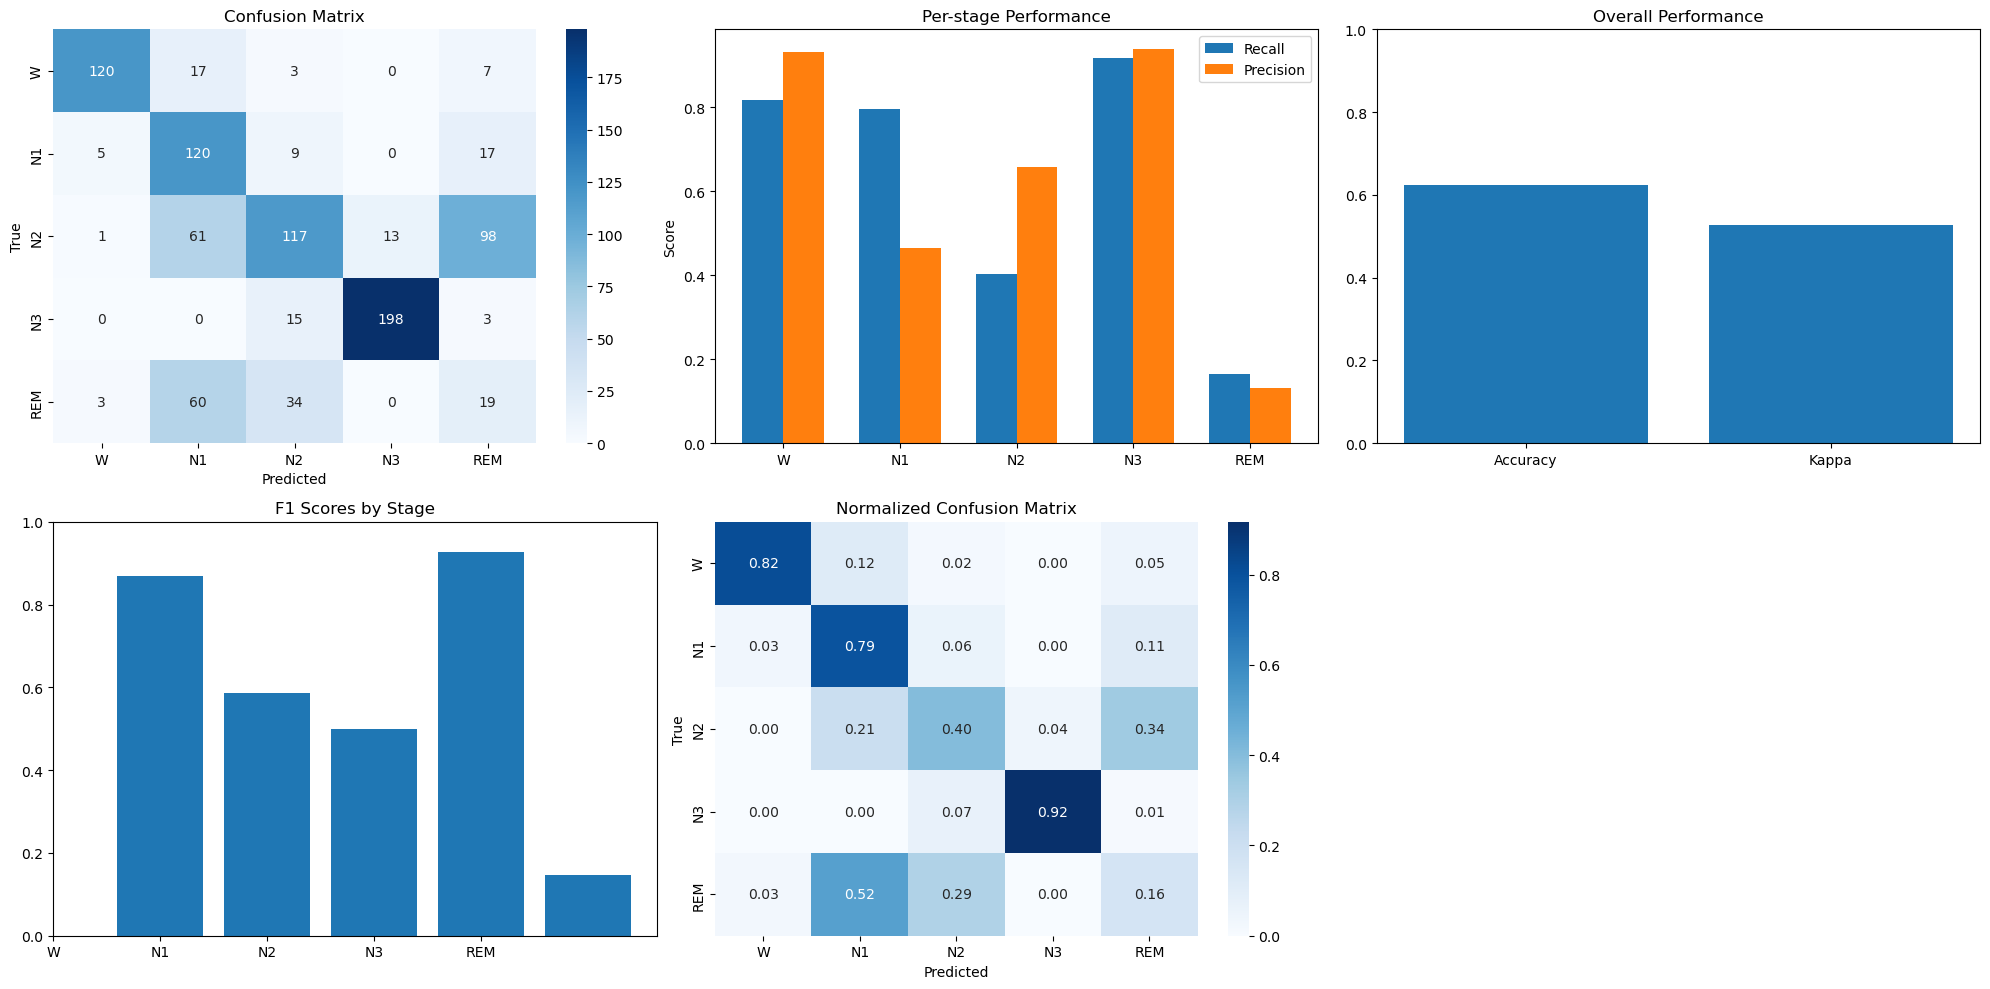


Numerical Results:
Overall Accuracy: 0.624
Kappa Score: 0.528

Per-stage Results:

Stage W:
  Recall: 0.816
  Precision: 0.930
  F1-Score: 0.870

Stage N1:
  Recall: 0.795
  Precision: 0.465
  F1-Score: 0.587

Stage N2:
  Recall: 0.403
  Precision: 0.657
  F1-Score: 0.500

Stage N3:
  Recall: 0.917
  Precision: 0.938
  F1-Score: 0.927

Stage REM:
  Recall: 0.164
  Precision: 0.132
  F1-Score: 0.146


In [32]:
stage_names = {
    1: 'W',
    2: 'N1',
    3: 'N2',
    4: 'N3',
    5: 'REM'
}
visualize_results(met, stage_names)

Now if we use only the 9 most relevant features from $Q-\alpha$.

In [33]:
# prediction by jmeans
pred2 = j_means_clustering(X_reduced)
predd2 = best_cluster_assignment(y, pred2) # optimal cluster assignement
met2 = evaluate_mapping(y, predd2)

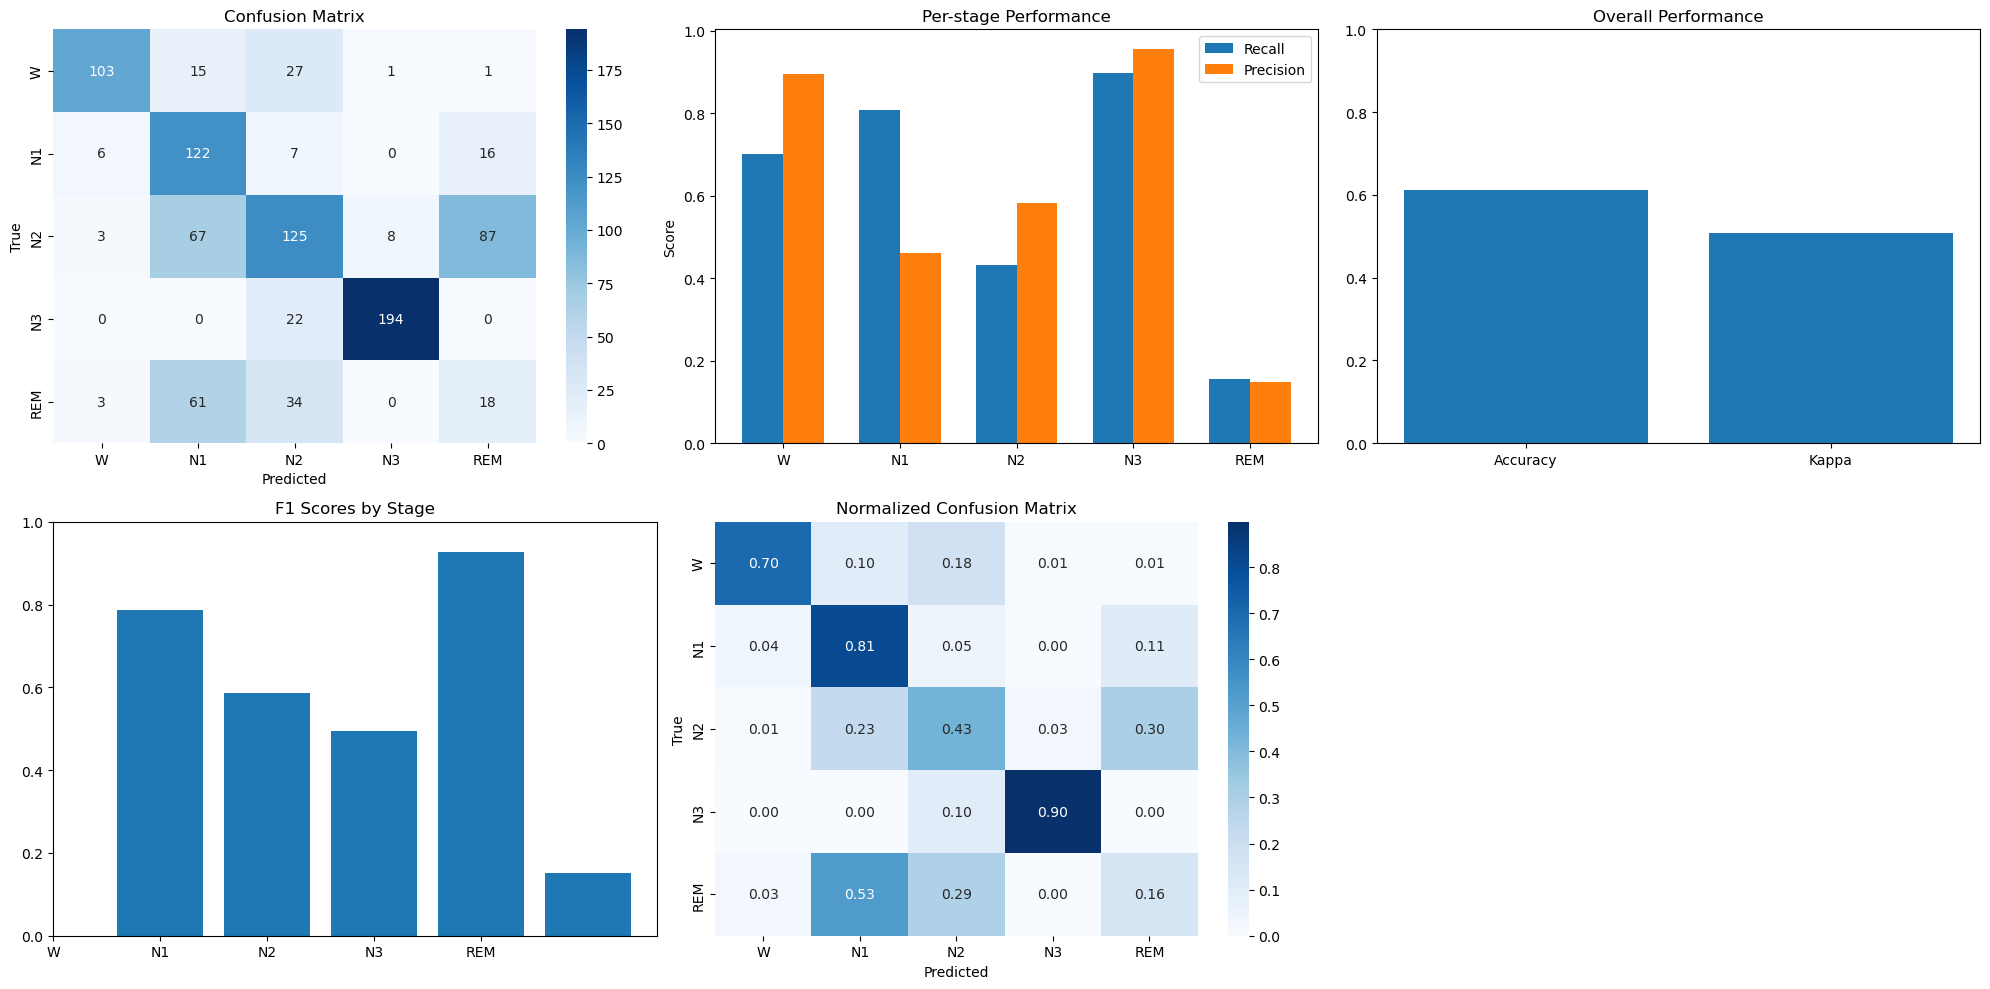


Numerical Results:
Overall Accuracy: 0.611
Kappa Score: 0.508

Per-stage Results:

Stage W:
  Recall: 0.701
  Precision: 0.896
  F1-Score: 0.786

Stage N1:
  Recall: 0.808
  Precision: 0.460
  F1-Score: 0.587

Stage N2:
  Recall: 0.431
  Precision: 0.581
  F1-Score: 0.495

Stage N3:
  Recall: 0.898
  Precision: 0.956
  F1-Score: 0.926

Stage REM:
  Recall: 0.155
  Precision: 0.148
  F1-Score: 0.151


In [34]:
visualize_results(met2, stage_names)

Despite the overall performance reduction with regard to the instance wiht all the features, we managed to accurately identify more N3 sleep stages instaces. Nevertheless, the overall performance between the two is closely good, despite the lack of substantial performance on the REM sleep stage, as it is mostly confused with the N2 sleep stage.

------------
Let's see now how each feature discriminates between the different sleep stages: Below the transparent lines correspond to each instance with different colors according to the sleep stage it corresponds to, and the non tranparent line represent the mean value for this specific class.

In [35]:
feature_names = feature_names[1:len(feature_names)-1]

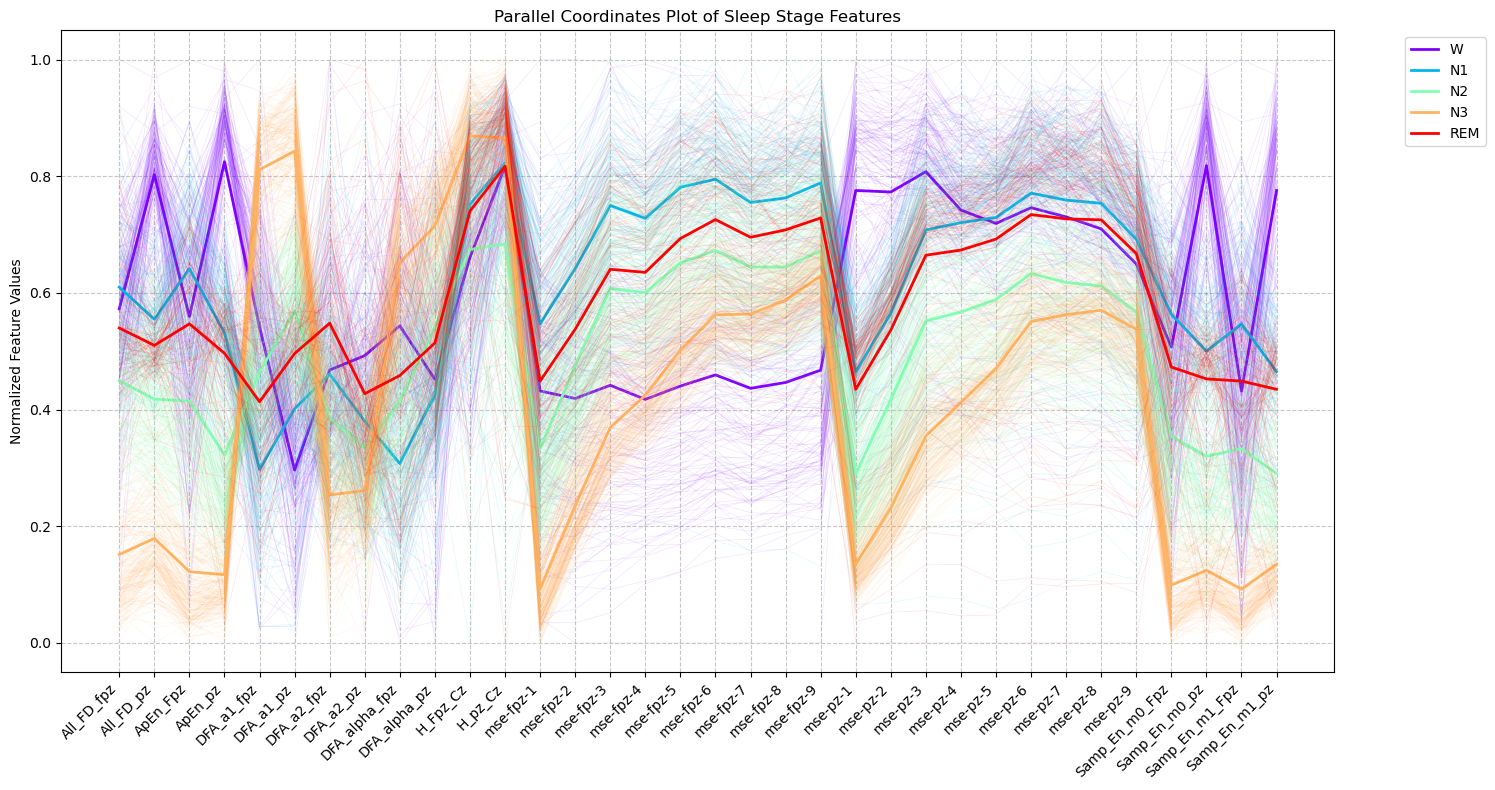

In [36]:
plt.figure(figsize=(15, 8))

# Normalize features to [0,1] for better visualization
normalized_data = data[feature_names].copy()
for feature in feature_names:
    min_val = normalized_data[feature].min()
    max_val = normalized_data[feature].max()
    normalized_data[feature] = (normalized_data[feature] - min_val) / (max_val - min_val)

# Get unique stages and assign colors
unique_stages = np.unique(y)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stages)))

# Create x-coordinates for parallel lines
x_coords = np.arange(len(feature_names))

# Plot lines for each class
for idx, stage in enumerate(unique_stages):
    mask = y == stage
    stage_data = normalized_data[mask]

    # Plot each sample as a line
    for _, row in stage_data.iterrows():
        plt.plot(x_coords, row, 
                color=colors[idx], 
                alpha=0.1,  # Make lines transparent
                linewidth=0.5)

    # Plot mean line for the class
    mean_values = stage_data.mean()
    plt.plot(x_coords, mean_values, 
            color=colors[idx], 
            linewidth=2, 
            label=stage_names[stage] if stage_names else f'Stage {stage}')

# Customize plot
plt.xticks(x_coords, feature_names, rotation=45, ha='right')
plt.ylabel('Normalized Feature Values')
plt.title('Parallel Coordinates Plot of Sleep Stage Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

We can conclude overall that there is a good discriminitave ability from each of the features, all thogh there is some confusion between certain features, for example `DFA_a1_fpz` and `DFA_a1_pz` have the same mean value for sleep stages N1 and W. Besides we can observe that the N2 (cyan) and  REM (red) lines are close to each other, which explains why the two sleep stages are the most confused according to the previous confusion matrix.

# 4. Other features 

According to this [article](https://www.researchgate.net/profile/Anna-Krakovska-2/publication/51480050_Automatic_sleep_scoring_A_search_for_an_optimal_combination_of_measures/links/5bb1c623299bf13e60596e46/Automatic-sleep-scoring-A-search-for-an-optimal-combination-of-measures.pdf), many other simply computed features are usable to distinguish between the different sleep stages in EEG data.

### a. Hjorth Parameters (Activity, Mobility, Complexity)

**Activity :** corresponds the the variance $\sigma^2$ of the signal. It represents the signal's power and indicates the surface of the power spectrum in the frequency domain: $Activity = var(y(t))$

**Mobility :** it represents the mean frequency of the signal: $Mobility = \sqrt{\frac{var(y'(t))}{var(y(t))}}$, where y'(t) is the first derivative of the signal

**Complexity :** represents the change in frequency as higher values indicate more irregularity, for example a pure sine wave has a complexity of 1: $Complexity = \frac{Mobility(y'(t))}{Mobility(y(t))}$

In [37]:
def hjorth(channel): 
    rows, cols = channel.shape
    all_sample1 = []
    all_sample2 = []
    all_sample3 = []
    for i in range(rows):
        time_series = channel[i, :]
        Hj1, Hj2, Hj3 = hjorth_parameters(time_series) #from utlis  
        all_sample1.append(Hj1)
        all_sample2.append(Hj2)
        all_sample3.append(Hj3)

    #val_moy = np.mean(all_sample)
    #print(f"Moyenne est:", fd_moy)
    return all_sample1, all_sample2, all_sample3

In [38]:
# for fpz channel
act_Fpz, mob_Fpz, comp_Fpz = hjorth(eeg_fpz)

In [39]:
# for pz channel
act_pz, mob_pz, comp_pz = hjorth(eeg_pz)

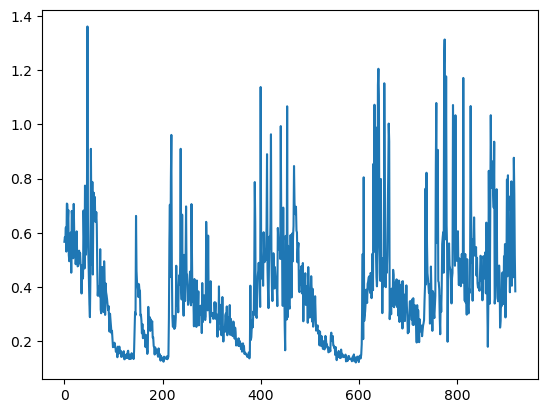

In [40]:
plt.plot(mob_Fpz)

------
### b. Zero Crossing Rate

It measures the rate at which a signal changes from positive to negative or vice versa. Mathematically, it's defined as: $ZCR = \frac{1}{T-1}\sum_{t=1}^{T-1} \mathbb{1}_{\{x_t x_{t-1} < 0\}}$

In [41]:
def zcr(channel): 
    rows, cols = channel.shape
    all_sample = []
    for i in range(rows):
        time_series = channel[i, :]
        val = zero_crossing_rate(time_series) #from utils  
        all_sample.append(val)

    #val_moy = np.mean(all_sample)
    #print(f"Moyenne est:", fd_moy)
    return all_sample

In [42]:
# for fpz channel
zcr_Fpz = zcr(eeg_fpz)

In [43]:
# for pz channel
zcr_pz = zcr(eeg_pz)

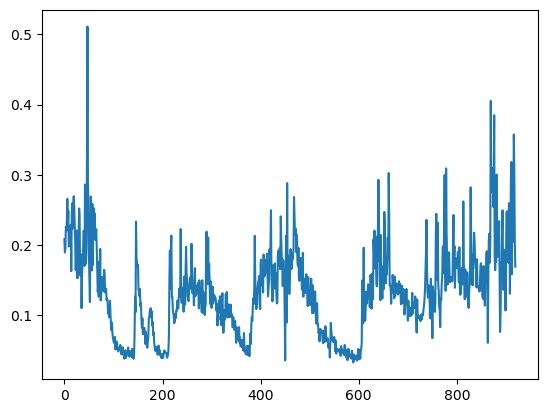

In [44]:
plt.plot(zcr_Fpz)

------
### c. Skewness and Kurtosis

**Skewness :** Measures the asymmetry of the probability distribution of the signal around its mean: $Skewness = \frac{E[(X-\mu)^3]}{\sigma^3} = \frac{\frac{1}{N}\sum_{i=1}^N(x_i-\mu)^3}{(\frac{1}{N}\sum_{i=1}^N(x_i-\mu)^2)^{3/2}}$

**Kurtosis :** Measures the "tailedness" or "peakedness" of the probability distribution: $Kurtosis = \frac{E[(X-\mu)^4]}{\sigma^4} = \frac{\frac{1}{N}\sum_{i=1}^N(x_i-\mu)^4}{(\frac{1}{N}\sum_{i=1}^N(x_i-\mu)^2)^2}$

In [45]:
def stats(channel): 
    rows, cols = channel.shape
    kurts = []
    skews = []
    for i in range(rows):
        time_series = channel[i, :]
        kurt, skew = signal_moments(time_series)  #from utils
        kurts.append(kurt)
        skews.append(skew)

    #val_moy = np.mean(all_sample)
    #print(f"Moyenne est:", fd_moy)
    return kurts, skews

In [46]:
# for fpz channel
Kurt_Fpz, Skew_Fpz = stats(eeg_fpz)

In [47]:
# for fpz channel
Kurt_pz, Skew_pz = stats(eeg_pz)

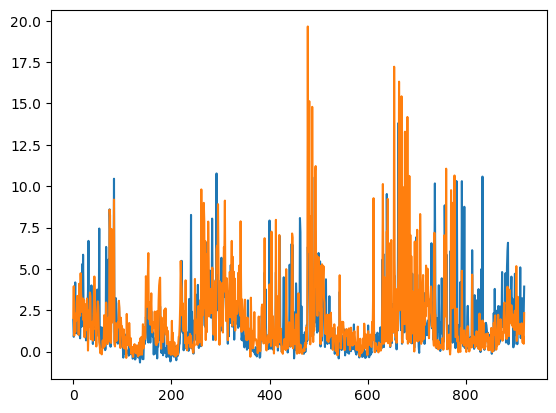

In [48]:
plt.plot(Kurt_Fpz)
plt.plot(Kurt_pz)
plt.show()

------------
Now we'll try to merge them with our data then try to reduce them using $Q-\alpha$ algorithm, and try classification for both instances.

In [49]:
# act_Fpz, mob_Fpz, comp_Fpz
data["act_Fpz"]= act_Fpz
data["mob_Fpz"]= mob_Fpz
data["comp_Fpz"]= comp_Fpz

data["act_pz"]= act_pz
data["mob_pz"]= mob_pz
data["comp_pz"]= comp_pz

# zcr_Fpz
data["zcr_Fpz"]= zcr_Fpz

data["zcr_pz"]= zcr_pz

# Kurt_Fpz, Skew_Fpz
data["Kurt_Fpz"]= Kurt_Fpz
data["Skew_Fpz"]= Skew_Fpz

data["Kurt_pz"]= Kurt_pz
data["Skew_pz"]= Skew_pz

In [50]:
# retrieve new data
# only leave features
scaler = StandardScaler()
X = data.drop(columns=['time', 'labels']).values
X_normalized = scaler.fit_transform(X)
X_normalized.shape

(920, 46)

We'll start with full features classification.

In [51]:
# full feature classification
# prediction by jmeans
pred3 = j_means_clustering(X_normalized)
predd3 = best_cluster_assignment(y, pred3) # optimal cluster assignement
met3 = evaluate_mapping(y, predd3)

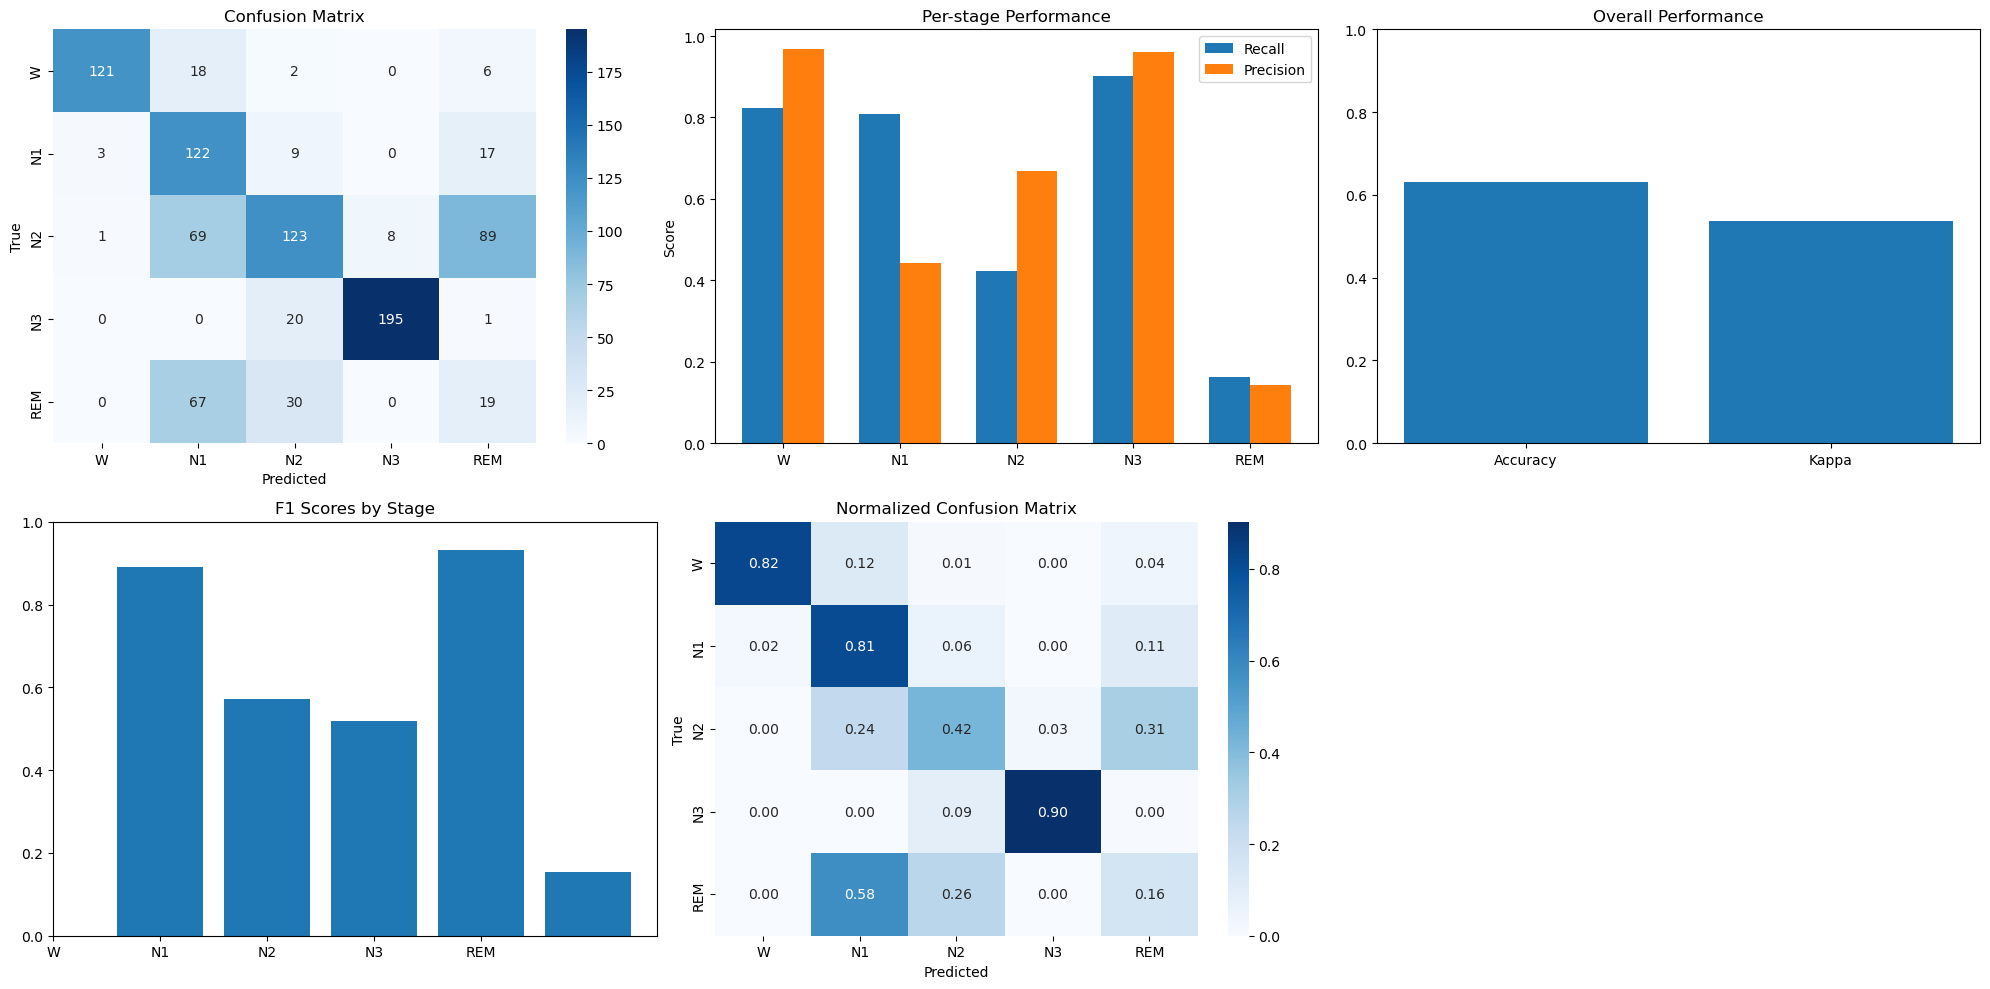


Numerical Results:
Overall Accuracy: 0.630
Kappa Score: 0.536

Per-stage Results:

Stage W:
  Recall: 0.823
  Precision: 0.968
  F1-Score: 0.890

Stage N1:
  Recall: 0.808
  Precision: 0.442
  F1-Score: 0.571

Stage N2:
  Recall: 0.424
  Precision: 0.668
  F1-Score: 0.519

Stage N3:
  Recall: 0.903
  Precision: 0.961
  F1-Score: 0.931

Stage REM:
  Recall: 0.164
  Precision: 0.144
  F1-Score: 0.153


In [52]:
visualize_results(met3, stage_names)

We can observe that the performance on REM has significantly increased with regard to last time.

---------
This time with reduced features.

In [53]:
# Apply Q-alpha algorithm
# we use the same variance threshold 0.98
selected_features, feature_weights = q_alpha(X_normalized)
X_reduced = X_normalized[:, selected_features]
print("number of features before reduction: ",X_normalized.shape[1])
print("number of features after reduction: ",X_reduced.shape[1])

number of features before reduction:  46
number of features after reduction:  13


In [54]:
feature_names = list(data.columns)
feature_names.remove('time')
feature_names.remove('labels')

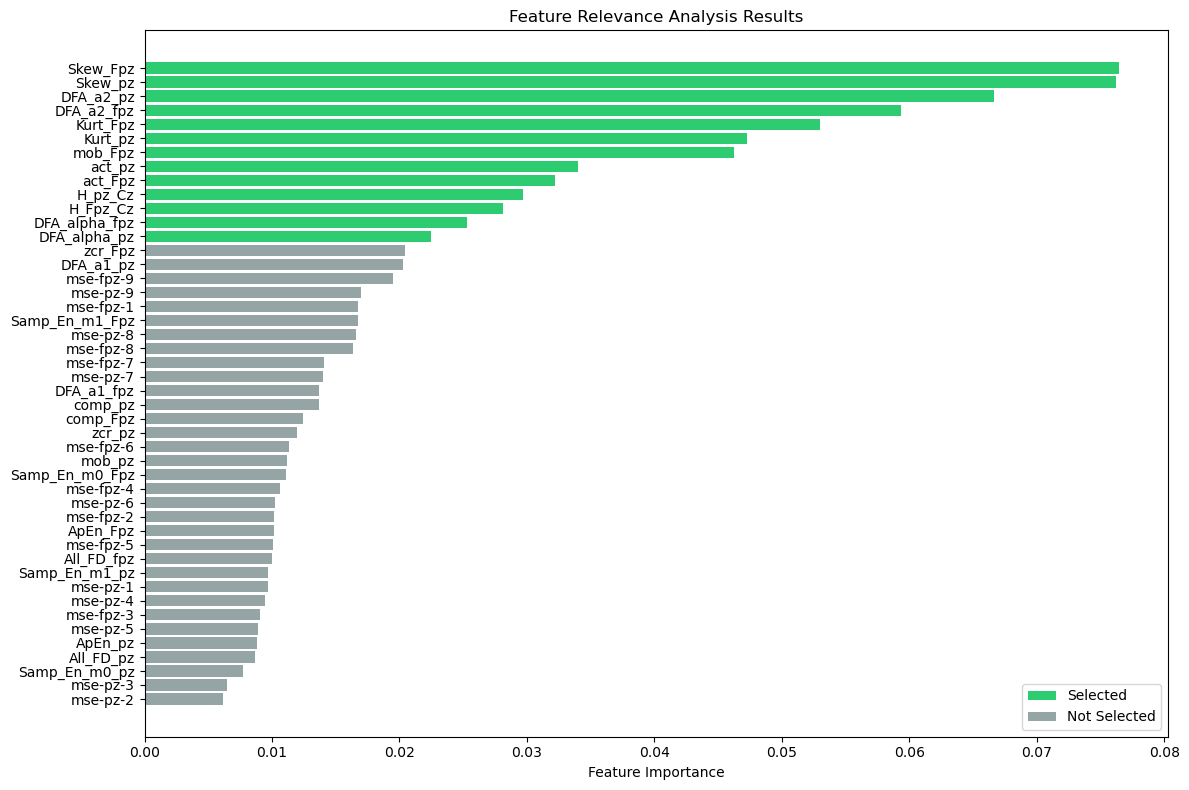


Selected Features:
-----------------
Skew_Fpz: 0.0765
Skew_pz: 0.0762
DFA_a2_pz: 0.0666
DFA_a2_fpz: 0.0594
Kurt_Fpz: 0.0530
Kurt_pz: 0.0473
mob_Fpz: 0.0462
act_pz: 0.0340
act_Fpz: 0.0322
H_pz_Cz: 0.0297
H_Fpz_Cz: 0.0281
DFA_alpha_fpz: 0.0253
DFA_alpha_pz: 0.0224


In [55]:
plt.figure(figsize=(12, 8))

# Create color array (blue for selected, gray for non-selected)
colors = ['#2ecc71' if i in selected_features else '#95a5a6' 
          for i in range(len(feature_weights))]

# Sort features by importance
sorted_idx = np.argsort(feature_weights)
pos = np.arange(len(feature_weights)) + .5

# Create horizontal bar plot
plt.barh(pos, feature_weights[sorted_idx], align='center', color=[colors[i] for i in sorted_idx])

# Customize the plot
plt.yticks(pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Relevance Analysis Results')

# Add a legend

legend_elements = [Patch(facecolor='#2ecc71', label='Selected'),
                  Patch(facecolor='#95a5a6', label='Not Selected')]
plt.legend(handles=legend_elements, loc='lower right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print selected features and their importance scores
print("\nSelected Features:")
print("-----------------")
for idx in selected_features:
    print(f"{feature_names[idx]}: {feature_weights[idx]:.4f}")

In [56]:
# full feature classification
# prediction by jmeans
pred4 = j_means_clustering(X_reduced)
predd4 = best_cluster_assignment(y, pred4) # optimal cluster assignement
met4 = evaluate_mapping(y, predd4)

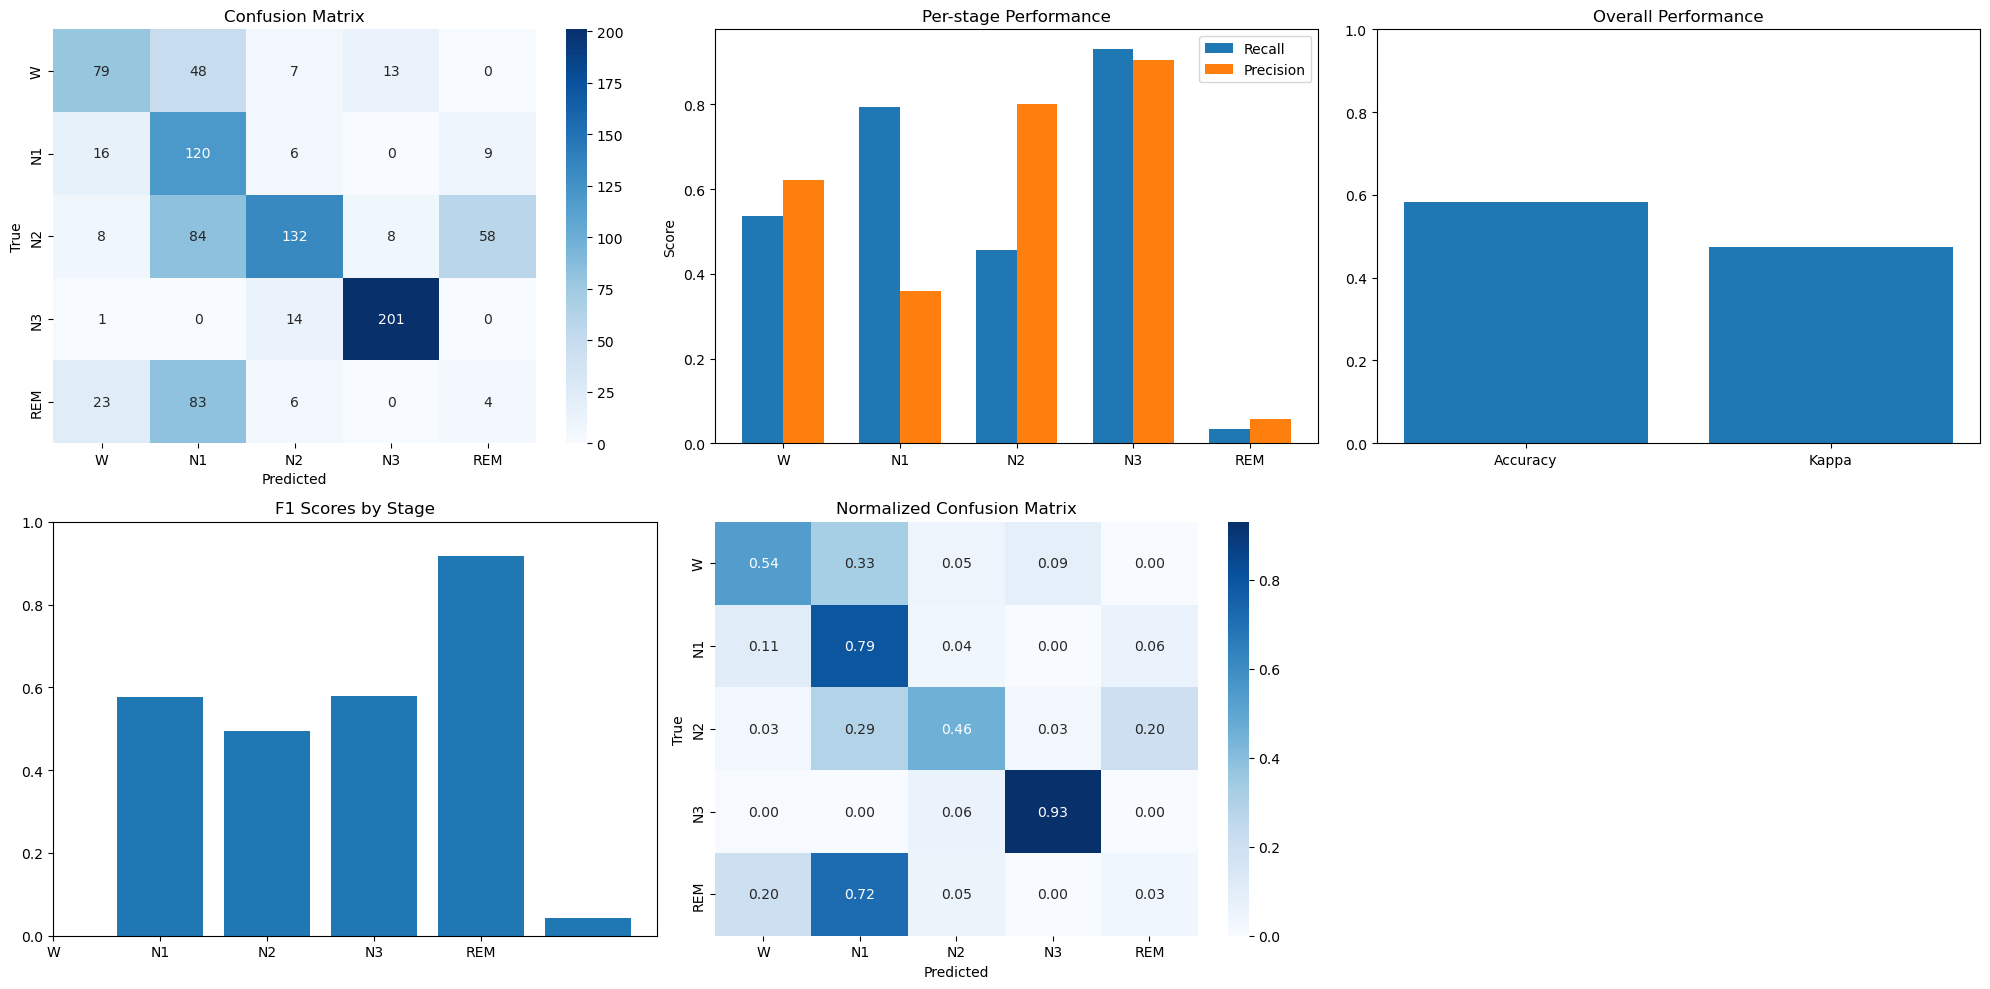


Numerical Results:
Overall Accuracy: 0.583
Kappa Score: 0.475

Per-stage Results:

Stage W:
  Recall: 0.537
  Precision: 0.622
  F1-Score: 0.577

Stage N1:
  Recall: 0.795
  Precision: 0.358
  F1-Score: 0.494

Stage N2:
  Recall: 0.455
  Precision: 0.800
  F1-Score: 0.580

Stage N3:
  Recall: 0.931
  Precision: 0.905
  F1-Score: 0.918

Stage REM:
  Recall: 0.034
  Precision: 0.056
  F1-Score: 0.043


In [57]:
visualize_results(met4, stage_names)

# 5. Experimenting on multiple subjects

After retrieving data for 13 subjects, and transforming it into a feasible one with features as columns, we'll try to evaluate the paper's proposed model average model, then ours.

In [58]:
# Initialize dictionaries to store results for each method
results = {
    'original': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'original_reduced': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'added_feats': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'added_feats_reduced': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})}
}

for i in range(13):
    data = pd.read_csv(f"data\\data{i}.csv")
    
    y = data["y"]
    data = data.drop('y', axis=1)
    
    scaler = StandardScaler()
    X_1 = data.drop(columns=['zcr_Fpz', 'zcr_pz', 'Kurt_Fpz', 'Skew_Fpz', 'Kurt_pz', 'Skew_pz',
                            'act_Fpz', 'mob_Fpz', 'comp_Fpz', 'act_pz','mob_pz', 'comp_pz']).values
    X1_normalized = scaler.fit_transform(X_1)
    selected_features, feature_weights = q_alpha(X1_normalized)
    X1_reduced = X1_normalized[:, selected_features]
    
    X_2 = data.values
    X2_normalized = scaler.fit_transform(X_2)
    selected_features, feature_weights = q_alpha(X2_normalized)
    X2_reduced = X2_normalized[:, selected_features]
    
    # results for all methods
    results_all = {
        'original': evaluate_mapping(y, best_cluster_assignment(y, j_means_clustering(X1_normalized))),
        'original_reduced': evaluate_mapping(y, best_cluster_assignment(y, j_means_clustering(X1_reduced))),
        'added_feats': evaluate_mapping(y, best_cluster_assignment(y, j_means_clustering(X2_normalized))),
        'added_feats_reduced': evaluate_mapping(y, best_cluster_assignment(y, j_means_clustering(X2_reduced)))
    }
    
    # results for each method
    for method, res in results_all.items():
        results[method]['accuracy'].append(res['accuracy'])
        results[method]['kappa'].append(res['kappa'])
        
        # per-stage metrics
        for stage, metrics in res['per_stage_metrics'].items():
            results[method]['per_stage'][stage]['recall'].append(metrics['recall'])
            results[method]['per_stage'][stage]['precision'].append(metrics['precision'])

In [59]:
# final statistics
final_stats = {}
for method in results:
    final_stats[method] = {
        'accuracy': {
            'mean': np.mean(results[method]['accuracy']),
            'std': np.std(results[method]['accuracy'])
        },
        'kappa': {
            'mean': np.mean(results[method]['kappa']),
            'std': np.std(results[method]['kappa'])
        },
        'per_stage': {}
    }
    
    # Calculate per-stage statistics
    for stage in results[method]['per_stage']:
        final_stats[method]['per_stage'][stage] = {
            'recall': {
                'mean': np.mean(results[method]['per_stage'][stage]['recall']),
                'std': np.std(results[method]['per_stage'][stage]['recall'])
            },
            'precision': {
                'mean': np.mean(results[method]['per_stage'][stage]['precision']),
                'std': np.std(results[method]['per_stage'][stage]['precision'])
            }
        }


for method, stats in final_stats.items():
    print(f"\nResults for {method}:")
    print(f"Accuracy: {stats['accuracy']['mean']:.3f} ± {stats['accuracy']['std']:.3f}")
    print(f"Kappa: {stats['kappa']['mean']:.3f} ± {stats['kappa']['std']:.3f}")
    print("\nPer-stage metrics:")
    for stage_num, metrics in stats['per_stage'].items():
        stage_name = stage_names[stage_num]
        print(f"\nStage {stage_name}:")
        print(f"Recall: {metrics['recall']['mean']:.3f} ± {metrics['recall']['std']:.3f}")
        print(f"Precision: {metrics['precision']['mean']:.3f} ± {metrics['precision']['std']:.3f}")
    print("-----------------------------------------------------------------------------------------------------------------")


Results for original:
Accuracy: 0.538 ± 0.095
Kappa: 0.385 ± 0.143

Per-stage metrics:

Stage W:
Recall: 0.565 ± 0.106
Precision: 0.814 ± 0.166

Stage N1:
Recall: 0.215 ± 0.167
Precision: 0.157 ± 0.118

Stage N2:
Recall: 0.502 ± 0.139
Precision: 0.684 ± 0.113

Stage N3:
Recall: 0.769 ± 0.344
Precision: 0.597 ± 0.357

Stage REM:
Recall: 0.565 ± 0.223
Precision: 0.349 ± 0.131
-----------------------------------------------------------------------------------------------------------------

Results for original_reduced:
Accuracy: 0.548 ± 0.072
Kappa: 0.398 ± 0.112

Per-stage metrics:

Stage W:
Recall: 0.581 ± 0.105
Precision: 0.659 ± 0.203

Stage N1:
Recall: 0.227 ± 0.149
Precision: 0.181 ± 0.135

Stage N2:
Recall: 0.503 ± 0.100
Precision: 0.706 ± 0.117

Stage N3:
Recall: 0.837 ± 0.269
Precision: 0.678 ± 0.327

Stage REM:
Recall: 0.484 ± 0.235
Precision: 0.317 ± 0.135
-----------------------------------------------------------------------------------------------------------------

Results

-----------
### Using K-means instead of J-means

In [60]:
def k_means_clustering(features, n_clusters=5, max_iter=300):
    """
    K-means clustering
    Parameters:
    - features: input data matrix (n_samples x n_features)
    - n_clusters: number of clusters (default=5 for sleep stages)
    - max_iter: maximum number of iterations (default=300)
    
    Returns:
    - labels: cluster assignments for each sample
    """
    # Initialize with random centroids
    n_samples = features.shape[0]
    centroids = features[np.random.choice(n_samples, n_clusters, replace=False)]
    labels = np.zeros(n_samples, dtype=int)
    
    for _ in range(max_iter):
        old_labels = labels.copy()
        
        # Assign points to nearest centroid
        distances = np.array([np.linalg.norm(features - c, axis=1) for c in centroids])
        labels = np.argmin(distances, axis=0)
        
        # Update centroids
        for i in range(n_clusters):
            mask = labels == i
            if np.any(mask):  # avoid empty clusters
                centroids[i] = np.mean(features[mask], axis=0)
        
        # Check convergence
        if np.all(labels == old_labels):
            break
    
    return labels

In [61]:
# Initialize dictionaries to store results for each method
results = {
    'original': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'original_reduced': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'added_feats': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})},
    'added_feats_reduced': {'accuracy': [], 'kappa': [], 'per_stage': defaultdict(lambda: {'recall': [], 'precision': []})}
}

for i in range(13):
    data = pd.read_csv(f"data\\data{i}.csv")
    
    y = data["y"]
    data = data.drop('y', axis=1)
    
    scaler = StandardScaler()
    X_1 = data.drop(columns=['zcr_Fpz', 'zcr_pz', 'Kurt_Fpz', 'Skew_Fpz', 'Kurt_pz', 'Skew_pz',
                            'act_Fpz', 'mob_Fpz', 'comp_Fpz', 'act_pz','mob_pz', 'comp_pz']).values
    X1_normalized = scaler.fit_transform(X_1)
    selected_features, feature_weights = q_alpha(X1_normalized)
    X1_reduced = X1_normalized[:, selected_features]
    
    X_2 = data.values
    X2_normalized = scaler.fit_transform(X_2)
    selected_features, feature_weights = q_alpha(X2_normalized)
    X2_reduced = X2_normalized[:, selected_features]
    
    # results for all methods
    results_all = {
        'original': evaluate_mapping(y, best_cluster_assignment(y, k_means_clustering(X1_normalized))),
        'original_reduced': evaluate_mapping(y, best_cluster_assignment(y, k_means_clustering(X1_reduced))),
        'added_feats': evaluate_mapping(y, best_cluster_assignment(y, k_means_clustering(X2_normalized))),
        'added_feats_reduced': evaluate_mapping(y, best_cluster_assignment(y, k_means_clustering(X2_reduced)))
    }
    
    # results for each method
    for method, res in results_all.items():
        results[method]['accuracy'].append(res['accuracy'])
        results[method]['kappa'].append(res['kappa'])
        
        # per-stage metrics
        for stage, metrics in res['per_stage_metrics'].items():
            results[method]['per_stage'][stage]['recall'].append(metrics['recall'])
            results[method]['per_stage'][stage]['precision'].append(metrics['precision'])

In [62]:
# final statistics
final_stats = {}
for method in results:
    final_stats[method] = {
        'accuracy': {
            'mean': np.mean(results[method]['accuracy']),
            'std': np.std(results[method]['accuracy'])
        },
        'kappa': {
            'mean': np.mean(results[method]['kappa']),
            'std': np.std(results[method]['kappa'])
        },
        'per_stage': {}
    }
    
    # Calculate per-stage statistics
    for stage in results[method]['per_stage']:
        final_stats[method]['per_stage'][stage] = {
            'recall': {
                'mean': np.mean(results[method]['per_stage'][stage]['recall']),
                'std': np.std(results[method]['per_stage'][stage]['recall'])
            },
            'precision': {
                'mean': np.mean(results[method]['per_stage'][stage]['precision']),
                'std': np.std(results[method]['per_stage'][stage]['precision'])
            }
        }


for method, stats in final_stats.items():
    print(f"\nResults for {method}:")
    print(f"Accuracy: {stats['accuracy']['mean']:.3f} ± {stats['accuracy']['std']:.3f}")
    print(f"Kappa: {stats['kappa']['mean']:.3f} ± {stats['kappa']['std']:.3f}")
    print("\nPer-stage metrics:")
    for stage_num, metrics in stats['per_stage'].items():
        stage_name = stage_names[stage_num]
        print(f"\nStage {stage_name}:")
        print(f"Recall: {metrics['recall']['mean']:.3f} ± {metrics['recall']['std']:.3f}")
        print(f"Precision: {metrics['precision']['mean']:.3f} ± {metrics['precision']['std']:.3f}")
    print("-----------------------------------------------------------------------------------------------------------------")


Results for original:
Accuracy: 0.535 ± 0.093
Kappa: 0.386 ± 0.131

Per-stage metrics:

Stage W:
Recall: 0.577 ± 0.102
Precision: 0.800 ± 0.190

Stage N1:
Recall: 0.199 ± 0.159
Precision: 0.178 ± 0.136

Stage N2:
Recall: 0.474 ± 0.103
Precision: 0.684 ± 0.115

Stage N3:
Recall: 0.760 ± 0.352
Precision: 0.589 ± 0.361

Stage REM:
Recall: 0.591 ± 0.247
Precision: 0.352 ± 0.129
-----------------------------------------------------------------------------------------------------------------

Results for original_reduced:
Accuracy: 0.541 ± 0.070
Kappa: 0.391 ± 0.109

Per-stage metrics:

Stage W:
Recall: 0.598 ± 0.119
Precision: 0.657 ± 0.169

Stage N1:
Recall: 0.261 ± 0.189
Precision: 0.167 ± 0.122

Stage N2:
Recall: 0.495 ± 0.095
Precision: 0.699 ± 0.132

Stage N3:
Recall: 0.840 ± 0.269
Precision: 0.671 ± 0.325

Stage REM:
Recall: 0.422 ± 0.253
Precision: 0.295 ± 0.124
-----------------------------------------------------------------------------------------------------------------

Results

---------

Below we'll stack up together the labels resulted from each of the 13 patients, and see how our algorithm performs overall on epochs classificaiton quantitatively.

In [83]:
def improved_j_means_clustering(features, n_clusters=5, tolerance_factor=4):
    """
    J-means clustering with k-means++ initialization
    
    Parameters:
    -----------
    features : array-like of shape (n_samples, n_features)
        Input data to be clustered
    n_clusters : int, default=5
        Number of clusters (5 for sleep stages)
    tolerance_factor : float, default=4
        Factor to determine outlier threshold
        
    Returns:
    --------
    labels : array of shape (n_samples,)
        Cluster labels for each point
    """
    def kmeans_pp_initialization(X, k):
        """K-means++ initialization"""
        n_samples = X.shape[0]
        # Choose first centroid randomly
        centroids = [X[np.random.randint(n_samples)]]
        
        # Choose remaining centroids
        for _ in range(k - 1):
            # Compute distances to closest centroid
            distances = np.min([np.linalg.norm(X - c, axis=1) ** 2 for c in centroids], axis=0)
            # Choose next centroid with probability proportional to distance squared
            probs = distances / distances.sum()
            cumulative_probs = np.cumsum(probs)
            r = np.random.random()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(X[j])
                    break
        return np.array(centroids)
    
    # Initialize with k-means++ centroids
    n_samples = features.shape[0]
    centroids = kmeans_pp_initialization(features, n_clusters)
    labels = np.zeros(n_samples, dtype=int)
    
    while True:
        old_labels = labels.copy()
        
        # Assign points to nearest centroid
        distances = np.array([np.linalg.norm(features - c, axis=1) for c in centroids])
        labels = np.argmin(distances, axis=0)
        
        # Find unoccupied points (J-means specific)
        intra_distances = []
        for i in range(n_clusters):
            mask = labels == i
            if np.any(mask):
                intra_distances.extend(distances[i, mask])
        
        threshold = tolerance_factor * np.std(intra_distances)
        min_distances = np.min(distances, axis=0)
        unoccupied = np.where(min_distances > threshold)[0]
        
        if len(unoccupied) == 0 or np.all(labels == old_labels):
            break
            
        # Update centroids
        for i in range(n_clusters):
            mask = labels == i
            if np.any(mask):
                centroids[i] = np.mean(features[mask], axis=0)
    
    return labels

In [84]:
Y, Y1, Y2, Y3, Y4 = [], [], [], [], []
for i in range(13):
    data = pd.read_csv(f"data\\data{i}.csv")
    
    y = data["y"]
    data = data.drop('y', axis=1)
    
    scaler = StandardScaler()
    X_1 = data.drop(columns=['zcr_Fpz', 'zcr_pz', 'Kurt_Fpz', 'Skew_Fpz', 'Kurt_pz', 'Skew_pz',
                            'act_Fpz', 'mob_Fpz', 'comp_Fpz', 'act_pz','mob_pz', 'comp_pz']).values
    X1_normalized = scaler.fit_transform(X_1)
    selected_features, feature_weights = q_alpha(X1_normalized)
    X1_reduced = X1_normalized[:, selected_features]
    
    X_2 = data.values
    X2_normalized = scaler.fit_transform(X_2)
    selected_features, feature_weights = q_alpha(X2_normalized)
    X2_reduced = X2_normalized[:, selected_features]
    
    # results for all methods
    y1 = best_cluster_assignment(y, improved_j_means_clustering(X1_normalized))
    y2 = best_cluster_assignment(y, improved_j_means_clustering(X1_reduced))
    y3 = best_cluster_assignment(y, improved_j_means_clustering(X2_normalized))
    y4 = best_cluster_assignment(y, improved_j_means_clustering(X2_reduced))
    
    Y.append(y)
    Y1.append(y1)
    Y2.append(y2)
    Y3.append(y3)
    Y4.append(y4)
    
Y = np.concatenate(Y)
Y1 = np.concatenate(Y1)
Y2 = np.concatenate(Y2)
Y3 = np.concatenate(Y3)
Y4 = np.concatenate(Y4)

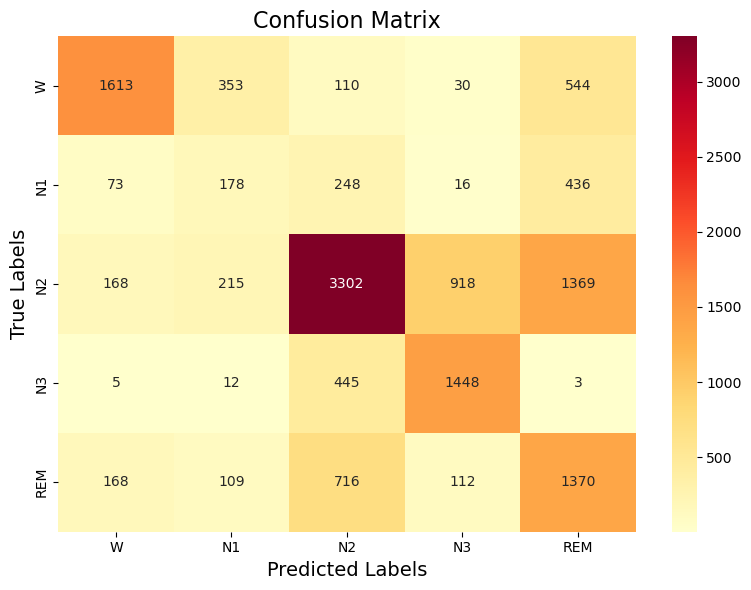

In [93]:
# confusion
cm = confusion_matrix(Y, Y1)
labels = [stage_names[i] for i in sorted(stage_names.keys())]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=labels, yticklabels=labels)

# Customize titles and labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

-------
Obtaining accuracy for each subject.

In [90]:
csv_files = [
    "SC4102E0",
    "SC4101E0",
    "SC4092E0",
    "SC4091E0",
    "SC4082E0",
    "SC4081E0",
    "SC4072E0",
    "SC4071E0",
    "SC4062E0",
    "SC4061E0",
    "SC4052E0",
    "SC4051E0",
    "SC4042E0"
]

# Initialize lists to store accuracies
acc1_list = []
acc2_list = []
acc3_list = []
acc4_list = []

for i in range(13):
    # Load data
    data = pd.read_csv(f"data\\data{i}.csv")
    
    # Separate features and target
    y = data["y"]
    data = data.drop('y', axis=1)
    
    # Standardize and process feature sets
    scaler = StandardScaler()
    
    # Feature set 1: X1_normalized
    X_1 = data.drop(columns=['zcr_Fpz', 'zcr_pz', 'Kurt_Fpz', 'Skew_Fpz', 'Kurt_pz', 'Skew_pz',
                            'act_Fpz', 'mob_Fpz', 'comp_Fpz', 'act_pz','mob_pz', 'comp_pz']).values
    X1_normalized = scaler.fit_transform(X_1)
    
    # Feature set 1 reduced: X1_reduced
    selected_features, _ = q_alpha(X1_normalized)
    X1_reduced = X1_normalized[:, selected_features]
    
    # Feature set 2: X2_normalized
    X_2 = data.values
    X2_normalized = scaler.fit_transform(X_2)
    
    # Feature set 2 reduced: X2_reduced
    selected_features, _ = q_alpha(X2_normalized)
    X2_reduced = X2_normalized[:, selected_features]
    
    # Calculate accuracies for each feature set
    acc1 = evaluate_mapping(y, best_cluster_assignment(y, improved_j_means_clustering(X1_normalized)))['accuracy']
    acc2 = evaluate_mapping(y, best_cluster_assignment(y, improved_j_means_clustering(X1_reduced)))['accuracy']
    acc3 = evaluate_mapping(y, best_cluster_assignment(y, improved_j_means_clustering(X2_normalized)))['accuracy']
    acc4 = evaluate_mapping(y, best_cluster_assignment(y, improved_j_means_clustering(X2_reduced)))['accuracy']
    
    # Store results
    acc1_list.append(acc1)
    acc2_list.append(acc2)
    acc3_list.append(acc3)
    acc4_list.append(acc4)

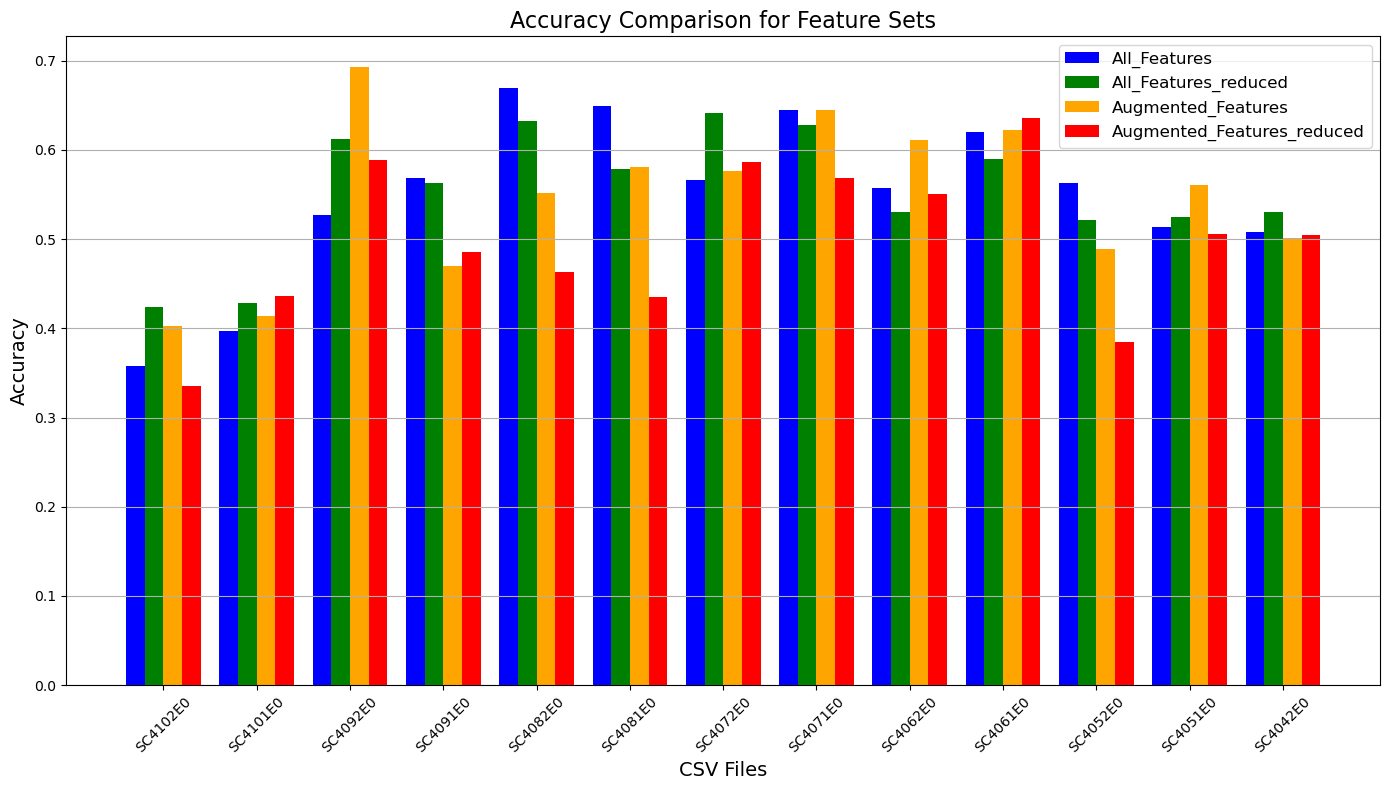

In [91]:
# Create a barplot
bar_width = 0.2
x = np.arange(len(csv_files))

plt.figure(figsize=(14, 8))

# Plot each accuracy
plt.bar(x - 1.5 * bar_width, acc1_list, width=bar_width, label='All_Features', color='blue')
plt.bar(x - 0.5 * bar_width, acc2_list, width=bar_width, label='All_Features_reduced', color='green')
plt.bar(x + 0.5 * bar_width, acc3_list, width=bar_width, label='Augmented_Features', color='orange')
plt.bar(x + 1.5 * bar_width, acc4_list, width=bar_width, label='Augmented_Features_reduced', color='red')

# Customize the plot
plt.xlabel('CSV Files', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Comparison for Feature Sets', fontsize=16)
plt.xticks(x, csv_files, rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()